# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')


In [3]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.describe()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
list(feat_info)

['attribute', 'information_level', 'type', 'missing_or_unknown']

In [7]:
def general_meta(in_file):
    
    file_size = in_file.size
    file_shape = in_file.shape
    file_ndim = in_file.ndim
    col_nan = in_file.isnull().sum()
    all_nan = in_file.isnull().sum().sum()
    prop_nan = all_nan / file_size
    print('overall size: ', file_size)
    print('shape: ', file_shape)
    print('number of dimensions: ', file_ndim)
    print('total number of NaN ', all_nan)
    print('proportion of data that is NaN ', prop_nan)
    print("col_nan shape: ", col_nan.shape)
    #col_nan
    return None


print("\n azdias \n")
general_meta(azdias)

#count NaN for full azdias set

print("\n feat_info \n")
general_meta(feat_info)


 azdias 

overall size:  75753785
shape:  (891221, 85)
number of dimensions:  2
total number of NaN  4896838
proportion of data that is NaN  0.0646414961312
col_nan shape:  (85,)

 feat_info 

overall size:  340
shape:  (85, 4)
number of dimensions:  2
total number of NaN  0
proportion of data that is NaN  0.0
col_nan shape:  (4,)


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.


#parse out 4th column
#print(feat_info['missing_or_unknown'])

# function to get unique values 
# Reference: https://www.geeksforgeeks.org/python-get-unique-values-list/

def unique(list1): 
    x = np.array(list1) 
    #print(np.unique(x))
    y = np.unique(x)
    return y

# function to determine whether a value is convertible to int:
# Reference: https://stackoverflow.com/questions/379906/how-do-i-parse-a-string-to-a-float-or-int
def is_int(value):
  try:
    int(int(value))
    return True
  except:
    return False

new_mi_list =[]
col = 0

for mi in feat_info['missing_or_unknown']:
    
    #replace brackets
    mi = mi.replace('[' , '')
    mi = mi.replace(']', '')
    
    #split at comma
    mi = mi.split(',')
    
    #convert "numerical strings" to ints    
    
    # The following checks whether each element can be converted to an int
    # if it can not be converted, it just returns the original value
    mi = [int(i) if is_int(i) else i for i in mi]
    
    #print(col, mi)
    
    new_mi_list.append(mi)
    col += 1
        
# print(new_mi_list)
 
#find unique elements in the list     
#print("new_mi_list: ", new_mi_list, '\n')
uniq_mi = unique(feat_info['missing_or_unknown'])
print(uniq_mi)


['[-1,0,9]' '[-1,0]' '[-1,9]' '[-1,XX]' '[-1,X]' '[-1]' '[0]' '[XX]' '[]']


In [9]:
#print examples of columns corresponding to unique combinations of 'feat_info' column 4 codes
example_cols = [0, 1, 3, 4, 12, 24, 57, 58, 59]

#azdias.iloc[0:10, example_cols]

In [10]:
#replace coded missing values with NaN
def col_wise(dframe, codes):
    
    new_df = dframe
    file_length = new_df.shape[1]
    
    col= list(new_df.columns)
    #print(col[0])
    
    for i in range(file_length):
        #print(i, col[i], codes[i], len(codes[i]))
        for j in range(len(codes[i])):
            #print('j, code element: ', j, codes[i][j])
            new_df[col[i]].replace(to_replace= codes[i][j], value= np.nan, inplace=True)
            
        #print(new_df[col[i]].head())
    
    return new_df

new_df2 = col_wise(azdias, new_mi_list)


In [11]:
#new_df2.head()
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

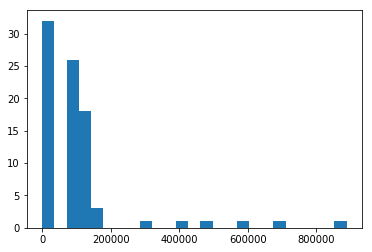

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

col_null=azdias.isnull().sum()

num_bins = 25 #86

plt.hist(col_null, bins = num_bins)
plt.show()


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


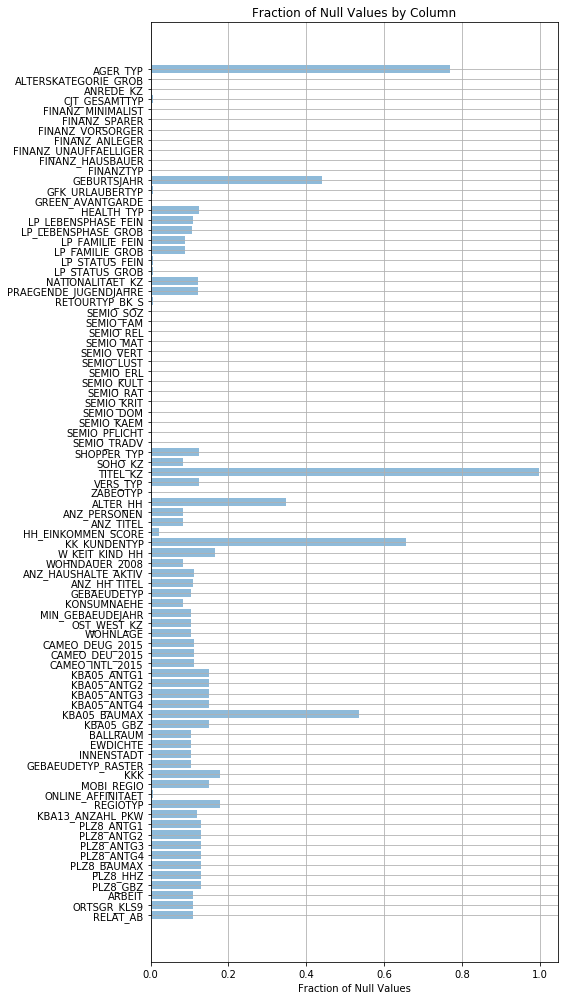

In [13]:
# Investigate patterns in the amount of missing data in each column.

#create a horizontal bar chart of missing values for each column

# Get ndArray of all column names 
columnsNamesArr = azdias.columns.values

y_pos = np.arange(len(columnsNamesArr))

plt.figure(figsize=(8,14))

plt.barh(y_pos, col_null/(azdias.shape[0]), align='center', alpha=0.5)

ax=plt.subplot()
ax.invert_yaxis()

plt.yticks(y_pos, columnsNamesArr)
plt.grid()
#plt.xlim(0,900000)
plt.xlabel('Fraction of Null Values')
plt.title('Fraction of Null Values by Column')
plt.tight_layout()
plt.show()

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# Eliminate columns missing greater than 40% of the data
drop_cols = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
azdias.drop(columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], inplace = True)


In [15]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)



***
<font color=blue>

By looking at the various supporting files- each element of the Azdias Feature Summary "column 4" are literally used to identify data points that effectively have no value. But it depends on the category. Luckily there is a 1 to 1 correspondence of codes per category

Relative to nearly 900,000 rows:

- A histogram of the Azdias data shows a majority of columns are missing less than 200,000, or roughly 20% of their respective data points.

- The histogram also shows there are some columns that are missing approximately 300,000 or more data points. One column in particular appears to be missing a large majority, if not nearly all of its data.

- The horizontal bar chart above shows even more detail what fraction of column data is missing. And which columns in particular are candidates for removal.

- TITEL_KZ- "Academic title flag" is the most obvious outlier

A pattern that is fairly apparent in both the histogram in the bar chart- there seems to be a "natural" boundary between the potential outliers and the columns to retain. Upon further investigation and consideration, that boundary was chosen to be approximately 35%; f less than 35% of the data is missing, then retain the column. Otherwise discard. Using this boundary, 5 total columns will be deleted:

1. AGER_TYP: Best-ager typology. Ostensibly seems to classify elderly people. Missing nearly 80% of the data. Presumably there is not a large proportion of elderly persons in the data set. Or else they weren't identified as such in this category

2. GEBURTSJHAR: Year of birth. Over 40% of this data is missing

3. TITEL_KZ: Academic title flag

4. KK_KUNDENTYP: Consumer pattern over the past 12 months

5. KBA05_BAUMAX: Most common building type within the microcell
<br>

ALTER_HH: Birthdate of head of household. Approximately 1/3 of this column is missing data. There are other categories that capture relative age... However, they seem to be confounded with other features. This category was retained, and therefore drove the threshold to the 35% rule

Looking over the various categories, there seems to be a lot of overlap / redundancy

</font>

***




#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [16]:
# How much data is missing in each row of the dataset?

print_every=50000
row_null_vector = []
for i in range(len(azdias.index)):
    if i % print_every == 0:
        print("Row numbers searched: ", i)
    #print("Nan in row ", i , " : " ,  azdias.iloc[i].isnull().sum())
    row_null_vector.append(azdias.iloc[i].isnull().sum())


Row numbers searched:  0
Row numbers searched:  50000
Row numbers searched:  100000
Row numbers searched:  150000
Row numbers searched:  200000
Row numbers searched:  250000
Row numbers searched:  300000
Row numbers searched:  350000
Row numbers searched:  400000
Row numbers searched:  450000
Row numbers searched:  500000
Row numbers searched:  550000
Row numbers searched:  600000
Row numbers searched:  650000
Row numbers searched:  700000
Row numbers searched:  750000
Row numbers searched:  800000
Row numbers searched:  850000


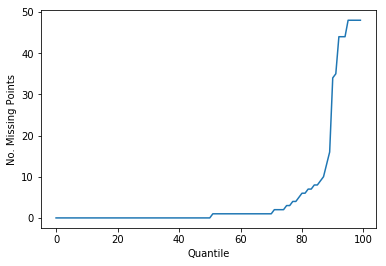

In [17]:
#Plot number of missing points vs quantiles to see the cumulative distribution of missing data
row_null_vector_df = pd.DataFrame(row_null_vector)

row_null_vector_df.describe()
quantile_vector=[]
for i in range(100):
    quantile_vector.append(row_null_vector_df.quantile(i/100))
    
#print(quantile_vector)

x = range(100)

plt.plot(x, quantile_vector);
plt.xlabel("Quantile");
plt.ylabel("No. Missing Points");


In [18]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# From above, it can be seen that 50% of the rows are not missing any values. 70% of the rows are missing one value or less
# Use the 70% criterion to divide the data- alternatively, rows missing 1 data point or less
# should be able to use row_null_vector
#row_null_vector_df.head(20)


In [19]:
#check that row_null_vector has the same proportion of missing datapoints at the <= -1 level as the plot
row_null_vector_df[(row_null_vector_df)<=1].count()/len(row_null_vector)


0    0.706951
dtype: float64

In [20]:
#Try inserting the null vector column into the dataframe, and split it that way.

azdias.insert(0, "Missing Points Criterion", row_null_vector)
#azdias.drop("Missing Points Criterion", axis = 1, inplace = True)



In [21]:
###azdias.head()

In [22]:
# Split rows into a dataframe where 1 or fewer points is missing (about 70% of the rows meet this criterion)
df_lte_1 = azdias[azdias['Missing Points Criterion'] <=1]


In [23]:
###df_lte_1.head()

In [24]:
# Split azdias into a data frame where more than one point is missing (about 30% of the rows)
df_gt_1 = azdias[azdias['Missing Points Criterion'] > 1]
###df_gt_1.head()

In [25]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#print(azdias.shape[0])
denominator=azdias.shape[0]
# Find Candidate columns
col_null2=azdias.isnull().sum()
columnsNamesArr2 = azdias.columns.values

cutoff_frac = .005 # Rather arbitrary fraction to define "few missing values"

count = 0
for i in range(len(col_null2)):

    if col_null2[i]/denominator <= cutoff_frac:
        count+=1
        print(count, columnsNamesArr2[i], col_null2[i], col_null2[i]/denominator)



1 Missing Points Criterion 0 0.0
2 ALTERSKATEGORIE_GROB 2881 0.00323264375503
3 ANREDE_KZ 0 0.0
4 FINANZ_MINIMALIST 0 0.0
5 FINANZ_SPARER 0 0.0
6 FINANZ_VORSORGER 0 0.0
7 FINANZ_ANLEGER 0 0.0
8 FINANZ_UNAUFFAELLIGER 0 0.0
9 FINANZ_HAUSBAUER 0 0.0
10 FINANZTYP 0 0.0
11 GREEN_AVANTGARDE 0 0.0
12 SEMIO_SOZ 0 0.0
13 SEMIO_FAM 0 0.0
14 SEMIO_REL 0 0.0
15 SEMIO_MAT 0 0.0
16 SEMIO_VERT 0 0.0
17 SEMIO_LUST 0 0.0
18 SEMIO_ERL 0 0.0
19 SEMIO_KULT 0 0.0
20 SEMIO_RAT 0 0.0
21 SEMIO_KRIT 0 0.0
22 SEMIO_DOM 0 0.0
23 SEMIO_KAEM 0 0.0
24 SEMIO_PFLICHT 0 0.0
25 SEMIO_TRADV 0 0.0
26 ZABEOTYP 0 0.0


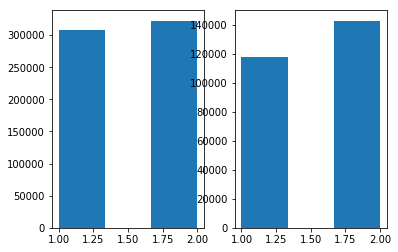

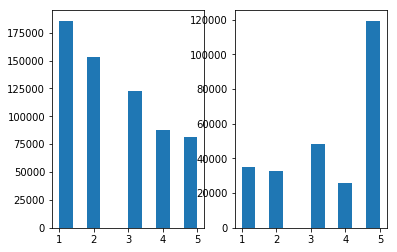

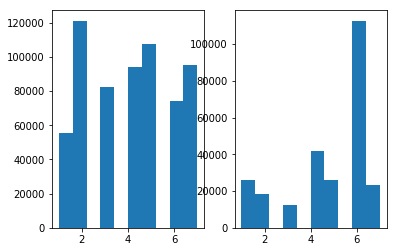

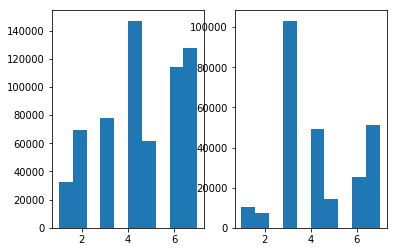

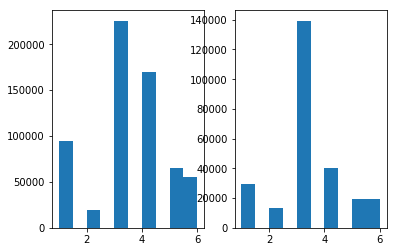

In [26]:
# Create a function to plot columns
def plot_col(col_1, col_2, num_bins = 3):
    
    f,a = plt.subplots(ncols=2)
    
    a[0].hist(col_1, bins = num_bins)
    a[1].hist(col_2, bins = num_bins)
    plt.show()
    f.tight_layout()

    return    


plot_col(df_lte_1['ANREDE_KZ'], df_gt_1['ANREDE_KZ'])

plot_col(df_lte_1['FINANZ_UNAUFFAELLIGER'], df_gt_1['FINANZ_UNAUFFAELLIGER'], num_bins = 10)
plot_col(df_lte_1['SEMIO_FAM'], df_gt_1['SEMIO_FAM'], num_bins = 10)
plot_col(df_lte_1['SEMIO_ERL'], df_gt_1['SEMIO_ERL'], num_bins =10 )
plot_col(df_lte_1['ZABEOTYP'], df_gt_1['ZABEOTYP'], num_bins =10)


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)


***
<font color=blue>

##### The number of missing points vs quantiles was plotted to see the cumulative distribution of missing data points per row
- 50% of the rows were not missing any values
- 70% of the rows were missing one value or less
- Above 70%, the cumulative amount of missing data per row tends to increase quickly. This created something of a natural "knee" in the distribution. As a result, *"one missing value or less"* was the threshold chosen to distinguish the two datasets 

##### A sampling of 5 different columns between the two datasets shows that there are apparent significant differences between the two.

For example 'FINANZ_UNAUFFAELLIGER' for the dataset with 0-1 missing values, the most frequent value is 1: "Very High". Whereas with the dataset having the greater number of missing values, the most frequent value is 5: "Very Low"

(I investigated many more than 5 different columns in this project, but only 5 are shown above) 

</font>

***


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [27]:
# How many features are there of each data type?

print(feat_info.type.value_counts())
print(feat_info.type.value_counts().sum())

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64
85


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [28]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#print(feat_info[feat_info.type == 'categorical'].attribute)
print(feat_info[feat_info.type == 'categorical'].index)
print()
#print(new_mi_list[feat_info[feat_info.type == 'categorical'].index])

#To attempt to determine which categorical variables are binary or multi-level
# Attempt to count the number of levels AFTER subtracting the "unknown or missing" value codes

# First step: Replace [''] with [] in new_mi_list- this was the parsing of the list of codes done earlier
# [[] if x== [''] else x for x in new_mi_list] doesn't seem to work

count = 0
for i in feat_info[feat_info.type == 'categorical'].index:
    count +=1
    if new_mi_list[i] == ['']:
        #print(count, [])
        new_mi_list[i] = []
    
    #print(count, new_mi_list[i], len(new_mi_list[i]))


Int64Index([0, 2, 3, 10, 12, 13, 17, 18, 19, 20, 21, 38, 39, 40, 41, 42, 47,
            52, 55, 57, 58],
           dtype='int64')



In [29]:
# First step part 2- Drop missing categories columns:
df_lte_1.drop("Missing Points Criterion", axis = 1, inplace = True)
df_gt_1.drop("Missing Points Criterion", axis = 1, inplace = True)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [30]:
df_lte_1.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0


In [31]:
df_gt_1.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,3.0,1,6.0,5,3,4,2,4,1,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,4.0
13,1.0,2,5.0,1,4,3,5,5,2,1,...,2.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,6.0,4.0


In [32]:
###print(new_mi_list)

In [33]:
feat_info['new_missing_or_unknown'] = new_mi_list
#feat_info.drop(['new missing info'], axis=1)
###feat_info.head()

In [34]:
feat_info = feat_info.drop(['missing_or_unknown'], axis=1)
###feat_info.head()

In [35]:
# Re insert attributes column into new_mi_list
# Create a dictionary of the attributes column for keys and the new_mi_list for values

'''new_mi_list_df = pd.DataFrame(new_mi_list)
new_mi_list_df.insert(0, 'attribute', feat_info['attribute'])
new_mi_list_df'''

att_mi_dict = {}

for i in range(len(new_mi_list)):
    att_mi_dict[feat_info.attribute[i]] = new_mi_list[i]
  

In [36]:
#print(att_mi_dict)
'''for i in att_mi_dict:
    print(i, att_mi_dict[i])'''

'for i in att_mi_dict:\n    print(i, att_mi_dict[i])'

In [37]:
#pull out dictionary key value pairs that correspond to columns that have been eliminated

#drop_cols = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

#att_mi_clean_dict = del att_mi_dict[drop_cols]
for i in drop_cols:
    del att_mi_dict[i]


In [38]:
#len(att_mi_dict)
'''count =0
for i in att_mi_dict:
    print(count, i, att_mi_dict[i])
    count += 1'''
    
#print(att_mi_dict)


'count =0\nfor i in att_mi_dict:\n    print(count, i, att_mi_dict[i])\n    count += 1'

In [39]:
feat_info_clipped=feat_info['attribute'].map(att_mi_dict)
#for i in range(len(feat_info_clipped)):
    #if isna(feat_info_clipped[i]):
    #(print(i, feat_info_clipped[i])
#print(feat_info_clipped)

In [40]:
#Initial column_mask
#print(feat_info_clipped.isna()== False)
column_mask = feat_info_clipped.isna()== False
'''for i in range(len(feat_info_clipped)):
    if feat_info_clipped[i].isna()==True:
        print(feat_info_clipped[i])'''

#print(column_mask)


'for i in range(len(feat_info_clipped)):\n    if feat_info_clipped[i].isna()==True:\n        print(feat_info_clipped[i])'

In [41]:
print(feat_info[feat_info.type == 'categorical'].index)


Int64Index([0, 2, 3, 10, 12, 13, 17, 18, 19, 20, 21, 38, 39, 40, 41, 42, 47,
            52, 55, 57, 58],
           dtype='int64')


In [42]:
# Get this sorted out once and for all
#convert pandas series to numpy
#column_mask= column_mask.to_numpy() #not working
array_mask = np.tile(column_mask, 4)

#array_mask = np.broadcast_to(column_mask, (85, 1))
#print("array_mask \n", array_mask)
print('column_mask shape ', column_mask.shape, type(column_mask))    
print('array_mask shape ', array_mask.shape)
print('feat_info shape ', feat_info.shape)
#reshape array_mask
a = np.reshape(array_mask, (85,-1))
#print(array_mask.shape)

'''for i in range(len(a)):
    print(i, column_mask[i], array_mask[i], a[i])'''
    
#Use the array mask to cut out the unused ROWS from feat_info
#print(array_mask)
feat_info_cut= np.ma.masked_array(feat_info, mask = array_mask)
#print(feat_info_cut)

column_mask shape  (85,) <class 'pandas.core.series.Series'>
array_mask shape  (340,)
feat_info shape  (85, 4)


In [43]:
type(column_mask)
#THE FOLLOWING STEP APPEARS TO BE KEY- convert series to array(?)
column_mask2=column_mask.values

In [44]:
#print(column_mask2)

In [45]:
array_mask_3 = np.repeat(column_mask2, 4)
array_mask_4 = np.reshape(array_mask_3, (85,-1))

In [46]:
#FINALLY GOT THIS TO WORK
array_mask_3.shape
array_mask_4.shape
#for i in range(len(array_mask_4)):
#    print(array_mask_4[i])


(85, 4)

In [47]:
#Apply mask to feat_info
#Use the array mask to cut out the unused columns from feat_info
#print(array_mask)
feat_info_cut2= np.ma.masked_array(feat_info, mask = np.invert(array_mask_4))

#print(feat_info_cut2)

In [48]:
#Convert array back into a Pandas Dataframe, drop NaN rows
feat_info_cut3=pd.DataFrame(feat_info_cut2).dropna()

#Add feat_info column labels back in
feat_info_cut3.columns = feat_info.columns.values
feat_info_cut3.head()
#feat_info_cut3.tail(10)

,attribute,information_level,type,new_missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]


In [49]:
len(feat_info_cut3)

80

In [50]:
df_lte_1.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0


In [51]:
'''
For j in feat_info_cut3[feat_info_cut3.type == 'categorical'].index:
    print(j, feat_info_cut3['attribute'][j])

'''

"\nFor j in feat_info_cut3[feat_info_cut3.type == 'categorical'].index:\n    print(j, feat_info_cut3['attribute'][j])\n\n"

In [52]:
# Invalid values have already been pulled out of each column 

'''
count = 0
for j in feat_info_cut3[feat_info_cut3.type == 'categorical'].index:
    count+=1

    print("j= ", j, "feature: ", feat_info_cut3['attribute'][j])
    print(df_lte_1[feat_info_cut3['attribute'][j]].value_counts().sort_index(), 
          "sum: ", df_lte_1[feat_info_cut3['attribute'][j]].value_counts().sum(),
         "count uniques: ", df_lte_1[feat_info_cut3['attribute'][j]].nunique())
    
'''

'\ncount = 0\nfor j in feat_info_cut3[feat_info_cut3.type == \'categorical\'].index:\n    count+=1\n\n    print("j= ", j, "feature: ", feat_info_cut3[\'attribute\'][j])\n    print(df_lte_1[feat_info_cut3[\'attribute\'][j]].value_counts().sort_index(), \n          "sum: ", df_lte_1[feat_info_cut3[\'attribute\'][j]].value_counts().sum(),\n         "count uniques: ", df_lte_1[feat_info_cut3[\'attribute\'][j]].nunique())\n    \n'

In [53]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Start with "OST_WEST_KZ"
# Replace "O" with 1 and "W" with 2

#df_lte_1.OST_WEST_KZ.replace('O', 1)
#df_lte_1.OST_WEST_KZ.replace('W', 2)

# Create a dictionary to remap the values 
dict = {'O' : 1, 'W' : 2} 
  
# Print the dictionary 
print(dict) 
  


{'O': 1, 'W': 2}


In [54]:
# Replace the values of the dataframe 
df_lte_1.replace({"OST_WEST_KZ": dict}, inplace = True) 

j = 55
print(df_lte_1[feat_info_cut3['attribute'][j]].value_counts().sort_index(), 
          "\n sum: ", df_lte_1[feat_info_cut3['attribute'][j]].value_counts().sum(),
         "count uniques: ", df_lte_1[feat_info_cut3['attribute'][j]].nunique())

1    133962
2    496088
Name: OST_WEST_KZ, dtype: int64 
 sum:  630050 count uniques:  2


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5821: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [55]:
# Create a dictionary of categorical variables and their corresponding numbers of levels
cat_levels_dict = {}

for j in feat_info_cut3[feat_info_cut3.type == 'categorical'].index:
    count+=1
    
    cat = feat_info_cut3['attribute'][j]
    lev = df_lte_1[feat_info_cut3['attribute'][j]].nunique()
    
    cat_levels_dict.update({cat : lev}) 



In [56]:
print(cat_levels_dict)

{'ANREDE_KZ': 2, 'CJT_GESAMTTYP': 6, 'FINANZTYP': 6, 'GFK_URLAUBERTYP': 12, 'GREEN_AVANTGARDE': 2, 'LP_FAMILIE_FEIN': 11, 'LP_FAMILIE_GROB': 5, 'LP_STATUS_FEIN': 10, 'LP_STATUS_GROB': 5, 'NATIONALITAET_KZ': 3, 'SHOPPER_TYP': 4, 'SOHO_KZ': 2, 'VERS_TYP': 2, 'ZABEOTYP': 6, 'GEBAEUDETYP': 7, 'OST_WEST_KZ': 2, 'CAMEO_DEUG_2015': 9, 'CAMEO_DEU_2015': 44}



#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

***
<font color=blue>
    
##### Of the categorical variables, the large majority were non binary. 
- After some deliberation, initially figuring that just eliminating them seemed to be excessive, while intending to "one-hot encode" instead, I ultimately decided to drop the multi-level categorical values from the analysis. 
- The following categorical values were non binary and will be removed:
 1. CJT_GESAMTTYP
 2. FINANZTYP
 3. GFK_URLAUBERTYP
 4. LP_FAMILIE_FEIN
 5. LP_FAMILIE_GROB
 6. LP_STATUS_FEIN
 7. LP_STATUS_GROB
 8. NATIONALITAET_KZ
 9. SHOPPER_TYP
 10. ZABEOTYP
 11. GEBAEUDETYP
 12. CAMEO_DEUG_2015
 13. CAMEO_DEU_2015  
<br>  
- The following categorical values were binary and numerical (and were therefore retained "as is"):
 1. ANREDE_KZ
 2. GREEN_AVANTGARDE
 3. SOHO_KZ
 4. VERS_TYP
  
##### The binary non-numeric category value "OST_WEST_KZ" was re-encoded
- "O" to 1, "W" to 2

</font>

***


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [57]:
for j in feat_info_cut3[feat_info_cut3.type == 'mixed'].index:
    print(j, feat_info_cut3['attribute'][j])

15 LP_LEBENSPHASE_FEIN
16 LP_LEBENSPHASE_GROB
22 PRAEGENDE_JUGENDJAHRE
56 WOHNLAGE
59 CAMEO_INTL_2015
79 PLZ8_BAUMAX


In [58]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

df_lte_1['PRAEGENDE_JUGENDJAHRE'].value_counts().sort_index()

1.0      15599
2.0       6300
3.0      44496
4.0      18474
5.0      69952
6.0      22895
7.0       3430
8.0     115279
9.0      29136
10.0     69238
11.0     28544
12.0     20078
13.0      4474
14.0    147253
15.0     33984
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [59]:
# Splitting PJ will be done somewhat manually. Data_dictionary.md decodes the decade and movement
# Interval type for decade
# Binary type for movement
# Re-encode decade such that 40s is 1, 50s is 2, etc
# For movement: 'Mainstream' set to 1, 'Avante Garde' set to 2

PJ_data = {'decade': [1,1,2,2,3,3,3,4,4,5,5,5,5,6,6], 'movement': [1,2,1,2,1,2,2,1,2,1,2,1,2,1,2]}
PJ_df = pd.DataFrame(PJ_data)
PJ_df

,decade,movement
0,1,1
1,1,2
2,2,1
3,2,2
4,3,1
5,3,2
6,3,2
7,4,1
8,4,2
9,5,1


In [60]:
# separate out PJ column as a new dataframe
# replace its rows with decade values saved as another dataframe
# repeat this time with the movement values as a second new dataframe
# add the two new dataframes, then remove original dataframe
df_decade = df_lte_1['PRAEGENDE_JUGENDJAHRE'].copy()
df_movement = df_lte_1['PRAEGENDE_JUGENDJAHRE'].copy()

for j in range(len(PJ_df)):
    df_decade.replace(to_replace= float(j+1), value= PJ_df['decade'][j], inplace=True)
    df_movement.replace(to_replace= float(j+1), value= PJ_df['movement'][j], inplace=True)
    #print(j,PJ_df['decade'][j],PJ_df['movement'][j])
    

In [61]:
df_movement.value_counts().sort_index()
#df_movement.value_counts().sort_index().sum()


1.0    481895
2.0    147237
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [62]:
df_decade.value_counts().sort_index()
#df_decade.value_counts().sort_index().sum()

1.0     21899
2.0     62970
3.0     96277
4.0    144415
5.0    122334
6.0    181237
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [63]:
# Find PRAEGENDE_JUGENDJAHRE index

'''count = 0

for col in df_lte_1.columns: 

    print(count, col) 
    count += 1'''

'count = 0\n\nfor col in df_lte_1.columns: \n\n    print(count, col) \n    count += 1'

In [64]:
df_decade.head()

1    6.0
2    6.0
4    4.0
5    2.0
6    5.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [65]:
df_movement.head()

1    1.0
2    2.0
4    1.0
5    1.0
6    1.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [66]:
# Using DataFrame.insert() to add a column 
#df.insert(2, "Age", [21, 23, 24, 21], True) 
# PJ column is 20, insert new columns:
df_lte_1.insert(21, "PJ_decade", df_decade, True)

In [67]:
df_lte_1.insert(21, "PJ_movement", df_movement, True)

In [68]:
'''
count = 0

for col in df_lte_1.columns: 
    if count > 15 and count <= 25:
        print(count, col)
 
    count += 1
    
    '''

'\ncount = 0\n\nfor col in df_lte_1.columns: \n    if count > 15 and count <= 25:\n        print(count, col)\n \n    count += 1\n    \n    '

In [69]:
# Drop the original PRAEGENDE_JUGENDJAHRE column
df_lte_1.drop("PRAEGENDE_JUGENDJAHRE", axis = 1, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [70]:
'''
count = 0

for col in df_lte_1.columns: 
    if count > 15 and count <= 25:
        print(count, col)
 
    count += 1
    
'''   

'\ncount = 0\n\nfor col in df_lte_1.columns: \n    if count > 15 and count <= 25:\n        print(count, col)\n \n    count += 1\n    \n'

In [71]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

'''
"CAMEO_INTL_2015" combines information on two axes: wealth and life stage. 
Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables 
(which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
If you decide to keep or engineer new features around the other mixed-type features, 
make sure you note your steps in the Discussion section.
'''

df_lte_1['CAMEO_INTL_2015'].value_counts().sort_index()

12      6952
13     19777
14     48860
15     13684
22     24121
23     14811
24     74699
25     31220
31     12503
32      8210
33      7508
34     15287
35      8477
41     75504
43     47042
44     12205
45     22246
51    112707
52     16915
54     38360
55     18962
Name: CAMEO_INTL_2015, dtype: int64

In [72]:
# Splitting CAMEO_INTL_2015:
# Wealth varies from 10 to 50 by 10s
# Life Stage varies from 1 to 5 by 1s

CI_2015_data = {'CI_WEALTH': range(10, 60, 10), 'CI_LIFE_STAGE': range(1, 6)}
CI_2015_df = pd.DataFrame(CI_2015_data)
#CI_2015_df

In [73]:
# Identify rows by 1s column

'''
# separate out PJ column as a new dataframe
# replace its rows with decade values saved as another dataframe
# repeat this time with the movement values as a second new dataframe
# add the two new dataframes, then remove original dataframe
df_decade = df_lte_1['PRAEGENDE_JUGENDJAHRE'].copy()
df_movement = df_lte_1['PRAEGENDE_JUGENDJAHRE'].copy()

for j in range(len(PJ_df)):
    df_decade.replace(to_replace= float(j+1), value= PJ_df['decade'][j], inplace=True)
    df_movement.replace(to_replace= float(j+1), value= PJ_df['movement'][j], inplace=True)
    #print(j,PJ_df['decade'][j],PJ_df['movement'][j])
    
'''

# Separate out CAMEO_INTL_2015 as a new dataframe
# replace its rows with modulo of the code as Life Stage

'''df_life_stage = df_lte_1['CAMEO_INTL_2015'].copy()
df_wealth = df_lte_1['CAMEO_INTL_2015'].copy()
'''

"df_life_stage = df_lte_1['CAMEO_INTL_2015'].copy()\ndf_wealth = df_lte_1['CAMEO_INTL_2015'].copy()\n"

In [74]:
#df_life_stage.head(10)
df_lte_1['CAMEO_INTL_2015'].head()
#CI_2015_df.head()

1    51
2    24
4    43
5    54
6    22
Name: CAMEO_INTL_2015, dtype: object

In [75]:
'''for j in feat_info_cut3[feat_info_cut3.type == 'categorical'].index:
    print(j, feat_info_cut3['attribute'][j])'''


#ls = df_lte_1['CAMEO_INTL_2015'] % 10
#print(51 % 10)
ones = []
tens = []
count = 0
#for j in range(len(df_lte_1)):
for j in df_lte_1['CAMEO_INTL_2015'].index:
    
    if j < 10:
        print(j, df_lte_1['CAMEO_INTL_2015'][j], 'ones: ', int(df_lte_1['CAMEO_INTL_2015'][j]) % 10,
        'tens: ', int(df_lte_1['CAMEO_INTL_2015'][j]) - (int(df_lte_1['CAMEO_INTL_2015'][j]) % 10))        
       
    count += 1
    
    ones.append(int(df_lte_1['CAMEO_INTL_2015'][j]) % 10)
    tens.append(int(df_lte_1['CAMEO_INTL_2015'][j]) - (int(df_lte_1['CAMEO_INTL_2015'][j]) % 10))

1 51 ones:  1 tens:  50
2 24 ones:  4 tens:  20
4 43 ones:  3 tens:  40
5 54 ones:  4 tens:  50
6 22 ones:  2 tens:  20
7 14 ones:  4 tens:  10
8 13 ones:  3 tens:  10
9 15 ones:  5 tens:  10


In [76]:
print(len(ones))
print(len(tens))

630050
630050


In [77]:
# The following two columns replace the one 'CAMEO_INTL_2015' column
# 'ones' corresponds with Life Stage
# 'tens' corresponds with Wealth
# E.g. what was 'CAMEO_INTL_2015' code 24 becomes 'ones' 4 and 'tens' code 20
#
count = 0

for col in df_lte_1.columns: 
    if col == 'CAMEO_INTL_2015':
    #if count > 15 and count <= 25:
        print(count, col)
 
    count += 1
    

56 CAMEO_INTL_2015


In [78]:
# 'CI_LIFE_STAGE' is new name for 'ones'
# 'CI_WEALTH' is new name for 'tens'
# Add these two columns in
df_lte_1.insert(56, "CI_LIFE_STAGE", ones, True)
df_lte_1.insert(56, "CI_Wealth", tens, True)

# Drop the original 'CAMEO_INTL_2015' column
df_lte_1.drop('CAMEO_INTL_2015', axis = 1, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [79]:
'''
count = 0

for col in df_lte_1.columns: 
    if count > 50 and count <= 60:
        print(count, col)
 
    count += 1
    
'''
    

'\ncount = 0\n\nfor col in df_lte_1.columns: \n    if count > 50 and count <= 60:\n        print(count, col)\n \n    count += 1\n    \n'

In [80]:
print(df_lte_1['LP_LEBENSPHASE_GROB'].value_counts().sort_index())

#print(df_lte_1['LP_LEBENSPHASE_GROB'].sort_values().unique())
grob_vals = df_lte_1['LP_LEBENSPHASE_GROB'].sort_values().unique()
print(grob_vals)

1.0     115623
2.0     129569
3.0      85285
4.0      43347
5.0      38019
6.0      22067
7.0      17421
8.0      19685
9.0      39931
10.0     34202
11.0     25555
12.0     59346
Name: LP_LEBENSPHASE_GROB, dtype: int64
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.]


In [81]:

grob_list_1 = df_lte_1.index[df_lte_1['LP_LEBENSPHASE_GROB'] == 1.0].tolist()



In [82]:
# create a dictionary of lists of indices...?
# Intent is to create a dictionary of lists of indices for grob and fein. Then compare the dictionaries to 
# hopefully determine whether fein dictionaries are subsets of grob dictionaries.
grob_dict = {}

#for j in range(1, 13):
for j in grob_vals:
    grob_dict[j] = df_lte_1.index[df_lte_1['LP_LEBENSPHASE_GROB'] == j].tolist()
    print(j, len(grob_dict[j]))

1.0 115623
2.0 129569
3.0 85285
4.0 43347
5.0 38019
6.0 22067
7.0 17421
8.0 19685
9.0 39931
10.0 34202
11.0 25555
12.0 59346


In [83]:
pd.DataFrame(grob_dict[2.0]).head()

,0
0,5
1,7
2,10
3,28
4,36


In [84]:
###print(df_lte_1['LP_LEBENSPHASE_FEIN'].value_counts().sort_index())
fein_vals = df_lte_1['LP_LEBENSPHASE_FEIN'].sort_values().unique()
###print(fein_vals)

In [85]:
fein_dict = {}

#for j in range(1, 13):
for j in fein_vals:
    fein_dict[j] = df_lte_1.index[df_lte_1['LP_LEBENSPHASE_FEIN'] == j].tolist()
    print(j, len(fein_dict[j]))

1.0 52528
2.0 33556
3.0 15209
4.0 14330
5.0 47925
6.0 35949
7.0 22026
8.0 23669
9.0 10006
10.0 17932
11.0 18930
12.0 16428
13.0 21988
14.0 14118
15.0 17344
16.0 11885
17.0 4627
18.0 4736
19.0 13918
20.0 14738
21.0 10550
22.0 5518
23.0 5999
24.0 9768
25.0 7653
26.0 2497
27.0 8563
28.0 8625
29.0 22545
30.0 17386
31.0 20381
32.0 13821
33.0 4829
34.0 9507
35.0 11219
36.0 8411
37.0 13440
38.0 10682
39.0 13463
40.0 13350
nan 0


In [86]:
print(df_lte_1.isnull().sum().sum())
#print(df_lte_1.isnull().sum())
pd.DataFrame(fein_dict[40.0]).head()
### Have NaN in dataframe still...

177875


,0
0,207
1,241
2,242
3,253
4,304


In [87]:
print(type(fein_vals))

nan_array = np.isnan(fein_vals)
not_nan_array = ~ nan_array
fein_vals_clean = fein_vals[not_nan_array]
print(fein_vals_clean)

<class 'numpy.ndarray'>
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.]


In [88]:
# Iterate through each list in GROB, check whether it contains all elements of a given FEIN list
# the key will be the grob_vals (i.e. j), the values will be fein_vals (i.e. k)
# Intentionally inactivated for now

'''
grob_fein_dict = {}

for j in grob_vals:
    #List1 = grob_dict[j]
    
    grob_list_1 = []

    for k in fein_vals_clean:
        #List2 = fein_dict[k]
        
        check =  all(item in grob_dict[j] for item in fein_dict[k])
        
        if check is True:
            print("The grob_dict list {} contains all elements of the fein_dict list {}".format(j, k))
            
            #grob_fein_dict[j].append(k)
            grob_list_1.append(k)
            
    print(j, 'k members of j: ', grob_list_1)
    
    grob_fein_dict[j] = grob_list_1
    
    '''

'\ngrob_fein_dict = {}\n\nfor j in grob_vals:\n    #List1 = grob_dict[j]\n    \n    grob_list_1 = []\n\n    for k in fein_vals_clean:\n        #List2 = fein_dict[k]\n        \n        check =  all(item in grob_dict[j] for item in fein_dict[k])\n        \n        if check is True:\n            print("The grob_dict list {} contains all elements of the fein_dict list {}".format(j, k))\n            \n            #grob_fein_dict[j].append(k)\n            grob_list_1.append(k)\n            \n    print(j, \'k members of j: \', grob_list_1)\n    \n    grob_fein_dict[j] = grob_list_1\n    \n    '

In [89]:
###grob_fein_dict

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

***
<font color=blue>

##### Splitting PRAEGENDE_JUGENDJAHRE was done somewhat manually. Data_dictionary.md decodes the decade and movement
- Interval type for decade
- Binary type for movement
- For this project, I re-encoded decade such that 40s is 1, 50s is 2, etc
- For movement, I did the following: 'Mainstream' was set to 1, 'Avante Garde' was set to 2

##### CAMEO_INTL_2015:
- The modulo function was used to separate out the values that were 'ones'
- Subtracting the result of the above left the 'tens' remaining
- 'CI_LIFE_STAGE' is new name for 'ones'. Its values vary from 1 to 5
- 'CI_WEALTH' is new name for 'tens'. These values were left to vary from 10 to 50
* After inserting the above two new columns, the CAMEO_INTL_2015 column was removed  

##### LP_LEBENSPHASE_GROB and LP_LEBENSPHASE_FEIN were investigated to check the following:
1. If GROB could suffice for FEIN (or vice versa) and/or whether keeping both would be redundant
2. If FEIN should be broken up into possibly one set of 3 categories and another set of 2 categories, or somehow otherwise re-combined
3. It was not made explicitly clear that each category of FEIN fit entirely within a category of GROB, I did not want to assume this to be the case
4. For that matter, it was not initially clear that FEIN and GROB were effectively the same data. Looking at Data_Dictionary.md, it seemed they *might* be. 

###### Checking elements of FEIN vs GROB show that each of the 40 sub-categories of FEIN fits entirely within one of the 12 categories of GROB, and all FEIN is represented in GROB
- The dictionary that was created (below) shows which sub-categories of FEIN (values 1.0- 40.0) appear in which categories of GROB (values 1.0- 12.0):  
{1.0: [1.0, 2.0, 3.0, 4.0],  
 2.0: [5.0, 6.0, 7.0, 8.0],  
 3.0: [9.0, 10.0, 11.0, 12.0, 13.0],  
 4.0: [14.0, 15.0, 16.0],  
 5.0: [17.0, 18.0, 19.0, 20.0],  
 6.0: [21.0, 22.0, 23.0],  
 7.0: [24.0, 25.0],  
 8.0: [26.0, 27.0, 28.0],  
 9.0: [29.0, 30.0],  
 10.0: [31.0, 32.0],  
 11.0: [33.0, 34.0, 35.0],  
 12.0: [36.0, 37.0, 38.0, 39.0, 40.0]}
 
- Note that there are not an equal number of categories of FEIN for each category of GROB (to be expected, given that 40 is not a multiple of 12). For example, GROB category 7.0 encompasses 2 categories of FEIN, whereas GROB categories 3.0 & 12.0 each contain 5 categories of FEIN
- Either FEIN or GROB would be appropriate to include, but not both, as that would be redundant and probably cause some bias unnecessarily 


</font>

***


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [90]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [91]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Drop the non binary categorical columns found earlier
'''
 1. CJT_GESAMTTYP
 2. FINANZTYP
 3. GFK_URLAUBERTYP
 4. LP_FAMILIE_FEIN
 5. LP_FAMILIE_GROB
 6. LP_STATUS_FEIN
 7. LP_STATUS_GROB
 8. NATIONALITAET_KZ
 9. SHOPPER_TYP
 10. ZABEOTYP
 11. GEBAEUDETYP
 12. CAMEO_DEUG_2015
 13. CAMEO_DEU_2015  
    '''
to_drop = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 
               'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 
               'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

# drop LP_LEBENSPHASE_GROB also

to_drop.append('LP_LEBENSPHASE_GROB')
#print(non_bin_cat)
#print(to_drop)

df_lte_1.drop(to_drop, axis = 1, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [92]:
'''
count = 0

for col in df_lte_1.columns: 

    print(count, col)
 
    count += 1
    
'''

'\ncount = 0\n\nfor col in df_lte_1.columns: \n\n    print(count, col)\n \n    count += 1\n    \n'

In [93]:
df_lte_1['OST_WEST_KZ'].describe()

count    630050.000000
mean          1.787379
std           0.409162
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max           2.000000
Name: OST_WEST_KZ, dtype: float64

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [94]:
# Create test data: read in part of the azdias data
df_test_1000 = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';', nrows=1000)

In [95]:
df_test_1000.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [96]:
'''
Is it safe to assume that the columns that are dropped from the azdias (general population) 
dataset are the same columns that will be dropped from the customer demographics data?

Yes, you should remove the same columns. 
As by removing those columns from your training set you are not using them 
for predictions so there is no point including them in the test dataset also.
Also, in your clean function make sure you hardcode the name 
of the columns you are dropping, which will clear your doubt.

'''

'\nIs it safe to assume that the columns that are dropped from the azdias (general population) \ndataset are the same columns that will be dropped from the customer demographics data?\n\nYes, you should remove the same columns. \nAs by removing those columns from your training set you are not using them \nfor predictions so there is no point including them in the test dataset also.\nAlso, in your clean function make sure you hardcode the name \nof the columns you are dropping, which will clear your doubt.\n\n'

In [97]:
# The cleaning function I am using reads in the dataframe, AND the parsed missing data codes from the 
# AZDIAS_Feature_Summary.csv file that was read in earlier

def clean_data(df, miss_codes):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # PART 1:
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    clean_df = df.copy()
    file_length = clean_df.shape[1]
    print('initial shape: ', clean_df.shape)
    #print("file length: ", file_length)
    col = list(clean_df.columns)

        #print(col[0])
    
    for i in range(file_length):
        #print(i, col[i], miss_codes[i], len(miss_codes[i]))
        for j in range(len(miss_codes[i])):
            #print('j, code element: ', j, miss_codes[i][j])
            clean_df[col[i]].replace(to_replace= miss_codes[i][j], value= np.nan, inplace=True)
            
        #print(clean_df[col[i]].head())
    
    # PART 2
    # remove selected columns and rows, ...
    
    # Eliminate columns missing greater than 35% of the data (same as general data)
    drop_cols = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    clean_df.drop(columns = drop_cols, inplace = True)
    
    print('shape after dropping 5 columns: ', clean_df.shape)

    # Eliminate rows: Use the same criteria as before- 
    # discard row if more than one data point is missing
    
    # Determine how much data is missing in each row
    # Track that number for each row

    print_every=50000
    row_null_track_vector = []
    for i in range(len(clean_df.index)):
        if i % print_every == 0:
            print("Row numbers searched: ", i)
        
        row_null_track_vector.append(clean_df.iloc[i].isnull().sum())
        
    #check characteristics of clean_df before further operations
    print('shape before removing rows: ', clean_df.shape)
    
    # Insert row_null_track_vector into the dataframe:    
    clean_df.insert(0, 'Missing Points Criterion', row_null_track_vector)
    
    
    # Use that new 'Missing Points Criterion' column 
    #to retain rows with no more than one missing value
    clean_df = clean_df[clean_df['Missing Points Criterion'] <= 1]
    #clean_df[clean_df['Missing Points Criterion'] <= 1, inplace = True]
    print('shape after removing rows: ', clean_df.shape)

    
    #Now that the filter column has been used, drop it back out of the dataframe
    clean_df.drop('Missing Points Criterion', axis = 1, inplace = True)
    
    print('shape after dropping missing points criterion: ', clean_df.shape)
    
    # PART 3:
    # select, re-encode, and engineer column values.
    
    # Re-encode categorical variable(s) to be kept in the analysis.

    # Start with "OST_WEST_KZ"
    # Replace "O" with 1 and "W" with 2

    # Create a dictionary to remap the values 
    dict = {'O' : 1, 'W' : 2} 
    
    # Replace the values of the dataframe 
    clean_df.replace({"OST_WEST_KZ": dict}, inplace = True) 
    
    
    # PRAEGENDE_JUGENDJAHRE:
    # Splitting PJ will be done somewhat manually. Data_dictionary.md decodes the decade and movement
    # Interval type for decade
    # Binary type for movement
    # Re-encode decade such that 40s is 1, 50s is 2, etc
    # For movement: 'Mainstream' set to 1, 'Avante Garde' set to 2

    PJ_data = {'decade': [1,1,2,2,3,3,3,4,4,5,5,5,5,6,6], 'movement': [1,2,1,2,1,2,2,1,2,1,2,1,2,1,2]}
    PJ_df = pd.DataFrame(PJ_data)
    #PJ_df
    
    # separate out PJ column as a new dataframe
    # replace its rows with decade values saved as another dataframe
    # repeat this time with the movement values as a second new dataframe
    # add the two new dataframes, then remove original dataframe
    df_decade = clean_df['PRAEGENDE_JUGENDJAHRE'].copy()
    df_movement = clean_df['PRAEGENDE_JUGENDJAHRE'].copy()

    for j in range(len(PJ_df)):
        df_decade.replace(to_replace= float(j+1), value= PJ_df['decade'][j], inplace=True)
        df_movement.replace(to_replace= float(j+1), value= PJ_df['movement'][j], inplace=True)
        #print(j,PJ_df['decade'][j],PJ_df['movement'][j])
    
    # Using DataFrame.insert() to add a column 
    #df.insert(2, "Age", [21, 23, 24, 21], True) 
    # PJ column is 20, insert new columns:
    clean_df.insert(21, "PJ_decade", df_decade, True)
    
    clean_df.insert(21, "PJ_movement", df_movement, True)
    
    # Drop the original PRAEGENDE_JUGENDJAHRE column
    clean_df.drop("PRAEGENDE_JUGENDJAHRE", axis = 1, inplace = True)
    
    print('shape after replacing PJ with 2 new columns: ', clean_df.shape)
    
    # CAMEO_INTL_2015:
    ones = []
    tens = []
    count = 0
    
    for j in clean_df['CAMEO_INTL_2015'].index:
        
        #print(j, clean_df['CAMEO_INTL_2015'][j])
    
        if j < 10:
            print(j, clean_df['CAMEO_INTL_2015'][j], 'ones: ', int(clean_df['CAMEO_INTL_2015'][j]) % 10,
            'tens: ', int(clean_df['CAMEO_INTL_2015'][j]) - (int(clean_df['CAMEO_INTL_2015'][j]) % 10))        
       
        count += 1
    
        ones.append(int(clean_df['CAMEO_INTL_2015'][j]) % 10)
        tens.append(int(clean_df['CAMEO_INTL_2015'][j]) - (int(clean_df['CAMEO_INTL_2015'][j]) % 10))
        
    # 'CI_LIFE_STAGE' is new name for 'ones'
    # 'CI_WEALTH' is new name for 'tens'
    # Add these two columns in
    clean_df.insert(56, "CI_LIFE_STAGE", ones, True)
    clean_df.insert(56, "CI_Wealth", tens, True)

    # Drop the original 'CAMEO_INTL_2015' column
    clean_df.drop('CAMEO_INTL_2015', axis = 1, inplace = True)
    
    
    # Drop the non binary categorical columns as before

    to_drop = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN',
               'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 
               'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

    # drop LP_LEBENSPHASE_GROB also

    to_drop.append('LP_LEBENSPHASE_GROB')
    #print(non_bin_cat)
    #print(to_drop)

    clean_df.drop(to_drop, axis = 1, inplace = True)
    
    print('final shape: ', clean_df.shape)
      
    # Return the cleaned dataframe.
    
    return clean_df
    
    

In [98]:
# Test the cleaning function on the test data set
post_clean_df = clean_data(df_test_1000, new_mi_list)

initial shape:  (1000, 85)
shape after dropping 5 columns:  (1000, 80)
Row numbers searched:  0
shape before removing rows:  (1000, 80)
shape after removing rows:  (652, 81)
shape after dropping missing points criterion:  (652, 80)
shape after replacing PJ with 2 new columns:  (652, 81)
1 51.0 ones:  1 tens:  50
2 24.0 ones:  4 tens:  20
4 43.0 ones:  3 tens:  40
5 54.0 ones:  4 tens:  50
6 22.0 ones:  2 tens:  20
7 14.0 ones:  4 tens:  10
8 13.0 ones:  3 tens:  10
9 15.0 ones:  5 tens:  10
final shape:  (652, 68)


In [99]:
#post_clean_df
###post_clean_df['CI_LIFE_STAGE'].head(10)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [100]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

#Check how many NaN exist in current dataset

#df_lte_1.isnull().sum().sum()
count_nan_in_df=df_lte_1.isnull().sum()

pd.set_option('display.max_columns', 85)
pd.set_option('display.max_rows', 70)
print (count_nan_in_df)

ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN           1
PJ_movement                 918
PJ_decade                   918
RETOURTYP_BK_S                0
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
SEMIO_RAT                     0
SEMIO_KRIT                    0
SEMIO_DOM                     0
SEMIO_KAEM                    0
SEMIO_PFLICHT                 0
SEMIO_TRADV                   0
SOHO_KZ                       0
VERS_TYP                      0
ALTER_HH                 170116
ANZ_PERS

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2e095c2b0>]], dtype=object)

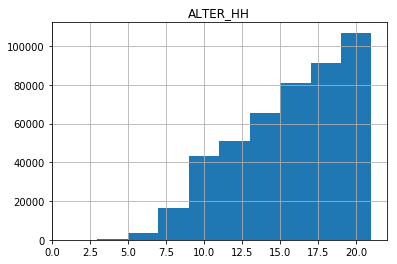

In [101]:
# ALTER_HH has the most missing values:
df_lte_1.hist(column = 'ALTER_HH')

'\nThe heat map below indicates the following mappings\n\n1 to 18\n2 to 17\n3 to 15\n4 to 10\n\nThis compares reasonably well with that worked out above, but the heat map is a more direct measurement\nSo use the heat map derived numbers for the missing values of ALTER_HH\n\n'

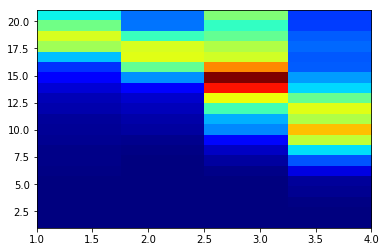

In [102]:
'''
### 2.1. ALTER_HH
Birthdate of head of household
-  0: unknown / no main age detectable
-  1: 1895-01-01 to 1899-12-31
-  2: 1900-01-01 to 1904-12-31
-  3: 1905-01-01 to 1909-12-31
-  4: 1910-01-01 to 1914-12-31
-  5: 1915-01-01 to 1919-12-31
-  6: 1920-01-01 to 1924-12-31
-  7: 1925-01-01 to 1929-12-31
-  8: 1930-01-01 to 1934-12-31
-  9: 1935-01-01 to 1939-12-31
- 10: 1940-01-01 to 1944-12-31
- 11: 1945-01-01 to 1949-12-31
- 12: 1950-01-01 to 1954-12-31
- 13: 1955-01-01 to 1959-12-31
- 14: 1960-01-01 to 1964-12-31
- 15: 1965-01-01 to 1969-12-31
- 16: 1970-01-01 to 1974-12-31
- 17: 1975-01-01 to 1979-12-31
- 18: 1980-01-01 to 1984-12-31
- 19: 1985-01-01 to 1989-12-31
- 20: 1990-01-01 to 1994-12-31
- 21: 1995-01-01 to 1999-12-31


### 1.2. ALTERSKATEGORIE_GROB
Estimated age based on given name analysis
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: < 30 years old
-  2: 30 - 45 years old
-  3: 46 - 60 years old
-  4: > 60 years old
-  9: uniformly distributed


Where ALTER_HH data is missing do the following:
Use ALTERSKATEGORIE_GROB to substitute-
ALTERSKATEGORIE_GROB 1 maps to ALTER_HH 20 ("Average" in the age range)
ALTERSKATEGORIE_GROB 2 maps to ALTER_HH 17 ("Average" in the age range)
ALTERSKATEGORIE_GROB 3 maps to ALTER_HH 14 ("Average" in the age range)
ALTERSKATEGORIE_GROB 4 maps to ALTER_HH 10 (> 60 years old. A study of German age demographics indicates an 'age centroid' of approx 73,
 which corresponds to ALTER_HH category code 10)
reference: https://population.un.org/wpp/Download/Standard/Population/


'''
#df_lte_1['ALTERSKATEGORIE_GROB', 'ALTER_HH'].head(10)

#df_lte_1['ALTER_HH'].head(10)

#df_lte_1.plot(x='ALTERSKATEGORIE_GROB', y='ALTER_HH', style='o')



x = df_lte_1['ALTERSKATEGORIE_GROB']
y = df_lte_1['ALTER_HH'].fillna(0)

# Big bins
plt.hist2d(x, y, bins=(4, 21), cmap=plt.cm.jet, range=((1, 4), (1, 21)));
#plt.show()

'''
The heat map below indicates the following mappings

1 to 18
2 to 17
3 to 15
4 to 10

This compares reasonably well with that worked out above, but the heat map is a more direct measurement
So use the heat map derived numbers for the missing values of ALTER_HH

'''




In [103]:
# create a dictionary that uses the values from ALTERSKATEGORIE_GROB as keys 
# and uses the values from ALTER_HH that we want to replace for the NaNs
# create 'copy_col' that starts with a copy of the ALTERSKATEGORIE_GROB column 
# and replaces values 1-4 with the dictionary values
# 
replace_dict = {1.0:18.0, 2.0:17.0, 3.0:15.0, 4.0:10.0}
#replace_dict

copy_col = df_lte_1['ALTERSKATEGORIE_GROB'].replace(to_replace = replace_dict)
print(copy_col)

1         18.0
2         15.0
4         15.0
5         18.0
6         17.0
7         18.0
8         15.0
9         15.0
10        15.0
19        15.0
21        17.0
22        18.0
27        15.0
28        15.0
31        17.0
32        18.0
33        17.0
36        15.0
37        10.0
38        17.0
41        18.0
43        18.0
44        15.0
45        10.0
47        10.0
49        17.0
50        15.0
51        18.0
52        18.0
55        15.0
56        17.0
57        18.0
58        17.0
59        17.0
63        17.0
          ... 
891177    10.0
891178    15.0
891179    10.0
891180    17.0
891182    18.0
891183    15.0
891186    18.0
891188    18.0
891189    17.0
891190    15.0
891191    10.0
891192    18.0
891193    10.0
891194    15.0
891195    10.0
891196    17.0
891197    15.0
891198    15.0
891199    17.0
891200    18.0
891201    15.0
891202    17.0
891204    15.0
891205    10.0
891206    18.0
891207    15.0
891209    18.0
891210    15.0
891211    15.0
891212    10.0
891213    

In [104]:
#

In [105]:
#df_lte_1['ALTERSKATEGORIE_GROB']
# Insert copy_col into the dataframe, into the column location adjacent to 'ALTERSKATEGORIE_GROB'

#DataFrameName.insert(loc, column, value, allow_duplicates = False)

df_lte_1.insert(df_lte_1.columns.get_loc('ALTERSKATEGORIE_GROB'), 'copy_col',copy_col)

In [106]:
df_lte_1.head()

,copy_col,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,PJ_movement,PJ_decade,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CI_Wealth,CI_LIFE_STAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,18.0,1.0,2,1,5,2,5,4,5,0,3.0,21.0,1.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,NaN,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,2,4.0,50,1,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,15.0,3.0,2,1,4,1,2,3,5,1,3.0,3.0,2.0,6.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,17.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,2,2.0,20,4,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
4,15.0,3.0,1,4,3,4,1,3,2,0,3.0,32.0,1.0,4.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,20.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,2,3.0,40,3,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,18.0,1.0,2,3,1,5,2,2,5,0,3.0,8.0,1.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,10.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,2,7.0,50,4,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,17.0,2.0,2,1,5,1,5,4,3,0,2.0,2.0,1.0,5.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,0.0,1.0,NaN,1.0,0.0,6.0,3.0,9.0,4.0,0.0,5.0,1992.0,2,5.0,20,2,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0


In [107]:
# Use .fillna() to replace the NaNs in 'ALTER_HH' with the values from 'copy_col'

df_lte_1.ALTER_HH.fillna(df_lte_1.copy_col, inplace=True)
print(df_lte_1.loc[df_lte_1['ALTERSKATEGORIE_GROB'] == 1]['ALTER_HH'])

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


1         18.0
5         10.0
7         14.0
22        18.0
32        19.0
41        20.0
43        19.0
51        21.0
52        19.0
57        18.0
79        21.0
82        17.0
95        18.0
132       20.0
148       17.0
152       18.0
161       16.0
164       18.0
203       16.0
222       16.0
223       14.0
226       18.0
232       18.0
246       18.0
251       18.0
281       18.0
289       19.0
295       18.0
300       18.0
305       17.0
321       19.0
322       18.0
335       16.0
350       20.0
357       13.0
          ... 
890955    15.0
890959    18.0
890966    18.0
890969    17.0
890972    19.0
890978    19.0
890979    20.0
891003    18.0
891006    20.0
891007    18.0
891025     9.0
891029    21.0
891046    13.0
891047    18.0
891065    18.0
891066    17.0
891081    18.0
891082    20.0
891084    11.0
891085    19.0
891089    17.0
891110    14.0
891131    15.0
891138    18.0
891167    15.0
891176    18.0
891182    18.0
891186    19.0
891188    19.0
891192    20.0
891200    

In [108]:
#Check that NaNs are eliminated from 'ALTER_HH'
df_lte_1['ALTER_HH'].isnull().sum()

0

In [109]:
# remove 'copy_col' from the dataframe
df_lte_1.drop(columns = ['copy_col'], inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [110]:
#Check how many NaN exist in current dataset

#df_lte_1.isnull().sum().sum()
count_nan_in_df=df_lte_1.isnull().sum()

pd.set_option('display.max_columns', 85)
pd.set_option('display.max_rows', 70)
print (count_nan_in_df)

ALTERSKATEGORIE_GROB        0
ANREDE_KZ                   0
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
FINANZ_VORSORGER            0
FINANZ_ANLEGER              0
FINANZ_UNAUFFAELLIGER       0
FINANZ_HAUSBAUER            0
GREEN_AVANTGARDE            0
HEALTH_TYP                  0
LP_LEBENSPHASE_FEIN         1
PJ_movement               918
PJ_decade                 918
RETOURTYP_BK_S              0
SEMIO_SOZ                   0
SEMIO_FAM                   0
SEMIO_REL                   0
SEMIO_MAT                   0
SEMIO_VERT                  0
SEMIO_LUST                  0
SEMIO_ERL                   0
SEMIO_KULT                  0
SEMIO_RAT                   0
SEMIO_KRIT                  0
SEMIO_DOM                   0
SEMIO_KAEM                  0
SEMIO_PFLICHT               0
SEMIO_TRADV                 0
SOHO_KZ                     0
VERS_TYP                    0
ALTER_HH                    0
ANZ_PERSONEN                0
ANZ_TITEL                   0
HH_EINKOMM

***

<font color=blue>
    
##### The large number of NaN in ALTER_HH was replaced with values estimated from another age related category ALTERSKATEGORIE_GROB
-  The two columns were plotted against each other with a heat map to see the degree of correlation
-  The correlation appeared adequate such that the missing values for ALTER_HH could be estimated from ALTERSKATEGORIE_GROB
-  This required 'mapping' the values to the codings in ALTER_HH

##### The NaN remaining in 6 categories were imputed with the 'most frequent' value for the category
</font>

***


In [111]:
'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
#Import sklearn imputer:
#from sklearn.impute import Imputer
from sklearn.preprocessing import Imputer


In [112]:
filling_missing = Imputer(strategy='most_frequent') 

df_lte_1_impute = pd.DataFrame(filling_missing.fit_transform(df_lte_1))

df_lte_1_impute.columns = df_lte_1.columns

df_lte_1_impute.index = df_lte_1.index

In [113]:
count_nan_in_df = df_lte_1_impute.isnull().sum()

pd.set_option('display.max_columns', 85)
pd.set_option('display.max_rows', 70)
print (count_nan_in_df)

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
LP_LEBENSPHASE_FEIN      0
PJ_movement              0
PJ_decade                0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
SOHO_KZ                  0
VERS_TYP                 0
ALTER_HH                 0
ANZ_PERSONEN             0
ANZ_TITEL                0
HH_EINKOMMEN_SCORE       0
W_KEIT_KIND_HH           0
WOHNDAUER_2008           0
ANZ_HAUSHALTE_AKTIV      0
A

In [114]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

### The following two lines were added to make it easier to apply the ss.fit_transform to the customer data
### Otherwise there is trouble with "The truth value of a DataFrame is ambiguous"

'''scaled_general = ss.fit_transform(df_lte_1_impute)

scaled_df = pd.DataFrame(scaled_general)'''

####################################

scaled_df = pd.DataFrame(ss.fit_transform(df_lte_1_impute))

scaled_df.columns = df_lte_1_impute.columns

scaled_df.index = df_lte_1_impute.index

In [115]:
scaled_df.head()

print(scaled_df.shape)

scaled_df.describe()

(630050, 68)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,PJ_movement,PJ_decade,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CI_Wealth,CI_LIFE_STAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05,6.300500e+05
mean,1.388493e-16,-7.155613e-17,-1.242844e-16,-2.359266e-17,-1.265793e-16,-8.070223e-17,1.858542e-16,6.694360e-17,1.050166e-16,3.766705e-18,-4.063305e-17,1.050166e-16,-2.515798e-16,3.514088e-17,-1.286798e-16,2.160555e-16,-1.939741e-17,-6.015451e-17,-1.224292e-16,-7.725129e-17,1.224292e-16,-7.849183e-17,6.960511e-17,1.050166e-16,1.212394e-16,2.364848e-16,-7.068775e-17,-1.299175e-16,-2.029961e-17,-2.898784e-16,-6.044773e-18,2.774280e-18,-6.270324e-18,-2.054772e-16,1.030092e-16,2.518956e-16,1.073624e-17,-1.750277e-17,1.558559e-16,1.062288e-14,-1.373607e-16,3.896397e-17,1.481533e-16,6.965022e-17,9.752835e-17,7.807456e-17,-5.618481e-17,-7.249216e-17,9.518262e-18,-1.557657e-16,-1.522020e-16,1.918877e-16,-7.098097e-17,2.041013e-16,-9.328799e-17,3.209594e-17,1.181437e-16,1.255193e-16,-9.049115e-17,-3.554687e-17,6.180103e-18,-3.112607e-17,5.521494e-17,-1.901510e-16,1.760202e-16,-1.136553e-16,3.193805e-17,4.488187e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.741744e+00,-1.023353e+00,-1.507318e+00,-1.141249e+00,-1.765726e+00,-1.221809e+00,-1.139475e+00,-1.592673e+00,-5.522287e-01,-1.590248e+00,-1.229489e+00,-5.522287e-01,-2.278906e+00,-1.659850e+00,-1.659358e+00,-1.602135e+00,-1.545559e+00,-1.443113e+00,-1.702485e+00,-1.560055e+00,-1.951522e+00,-1.602044e+00,-1.687004e+00,-1.990804e+00,-1.924716e+00,-1.696372e+00,-1.629061e+00,-1.519123e+00,-9.257737e-02,-1.067224e+00,-3.914630e+00,-1.591349e+00,-6.05

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

***

<font color=blue>
    
##### The StandardScaler was chosen
-  As recommended for this project


</font>

***

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [116]:
# Apply PCA to the data.

from sklearn.decomposition import PCA

def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.
    
    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform
           
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    # X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    #X_pca = pca.fit_transform(X)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

pca, X_pca = do_pca(68, scaled_df)

In [117]:
X_pca.shape


(630050, 68)

In [118]:
# Scree plot from helper functions provided in the course
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(14, 10)) # 10, 6
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

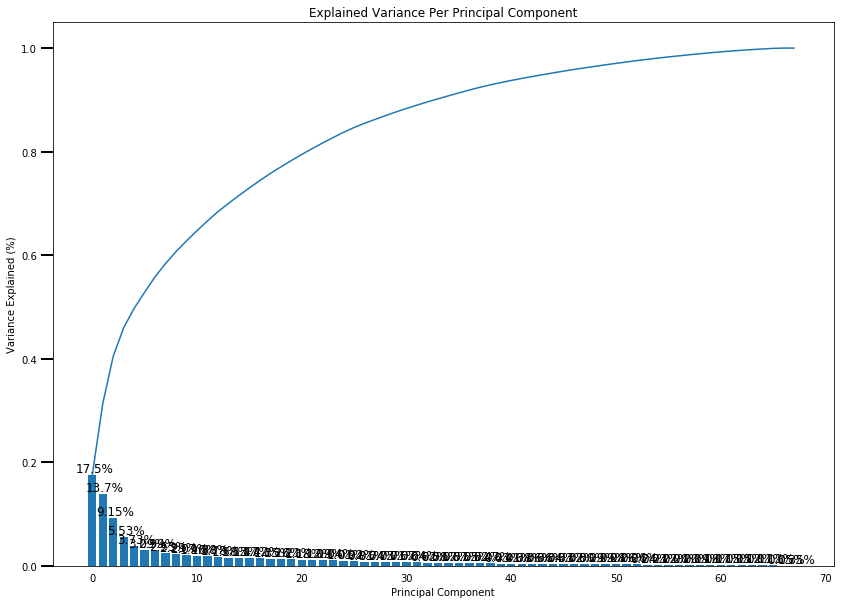

In [119]:
# 68 Features in scaled_df

#Use the scree plot 
scree_plot(pca)

In [120]:
# based on the scree plot above, it appears we can safely reduce features to half per the instructions
pca, X_pca = do_pca(34, scaled_df)

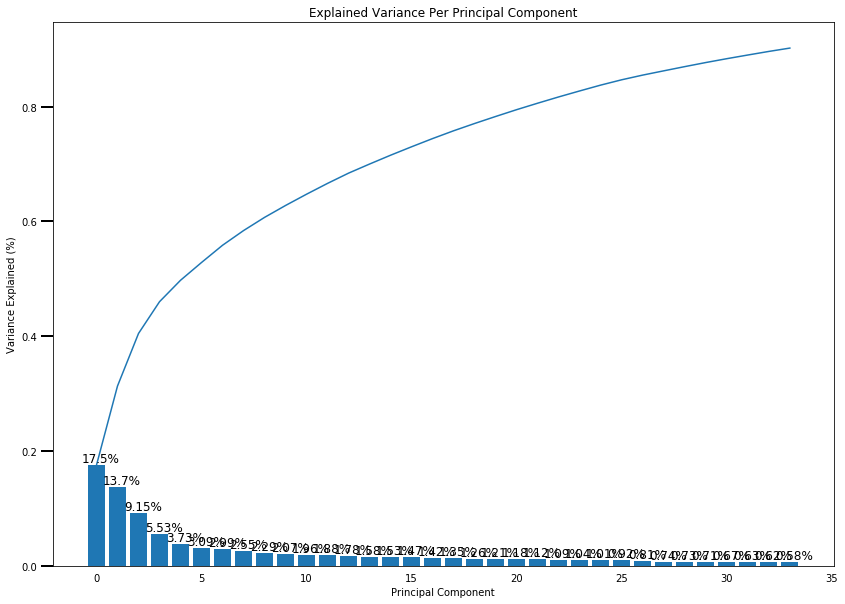

In [121]:
#Scree plot with half the features (34)
scree_plot(pca)

In [122]:
# based on the scree plot above, 27 principal components seem to capture about 80% of the variance
pca, X_pca = do_pca(27, scaled_df)

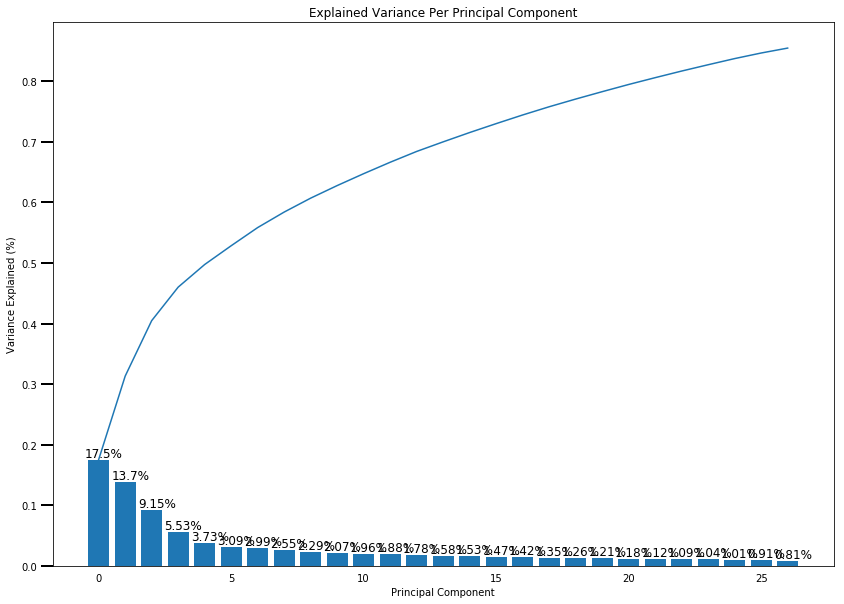

In [123]:
#Scree plot with 27 principal components
scree_plot(pca)

In [124]:
print(pca.explained_variance_ratio_)
pca.explained_variance_ratio_.sum()

[ 0.17543167  0.13772304  0.09155234  0.05533194  0.03734846  0.03099753
  0.02999994  0.02558608  0.02299229  0.020738    0.01965244  0.01884892
  0.01785095  0.01583902  0.0153779   0.01470258  0.01428766  0.01356154
  0.01269368  0.0121948   0.0118837   0.0112462   0.01092888  0.01041833
  0.01015909  0.00919822  0.00813048]


0.8546756855890959

In [125]:
# The following will store the reduced data that will be used henceforth
pca_27, X_pca_27 = do_pca(27, scaled_df)

In [126]:
# Investigate the variance accounted for by each principal component.



In [127]:
# Re-apply PCA to the data while selecting for number of components to retain.



### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

***

<font color=blue>

#### Given 68 initial components, PCA shows that approximately 85% of the variation can be explained with 27 Principal Components
- The first 5 components explain nearly 50% of the variation
- After about 25 components, each additional component explains less than 1% additional variance
- I decided that 85% of explained variance was a good compromise, eliminating 60% of the principal components while still retaining 27 for further analysis

</font>

***

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [128]:
# From helper functions provided in the course

def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [129]:
# PCA on the first few Principal Components
pca, X_pca = do_pca(3, scaled_df)

In [180]:
#pca_results(scaled_df, pca)

In [131]:
#print(pca.components_)
print(type(pca.components_))
print(pca.components_.shape)
#print(pca)
#print(X_pca)
#print(type(scaled_df.keys()))
#print(scaled_df.keys().shape)
#print(pca.components_[0])
#print(list(scaled_df.columns.values))

print()
print(pca.components_[0].tolist())

<class 'numpy.ndarray'>
(3, 68)

[-0.12965261494360955, -0.0011283334675500066, -0.2105890105761777, 0.1486070577185206, -0.12131510264886436, 0.0726958721732511, 0.08126768713956453, 0.14433840001111709, -0.10842979843908625, 0.035384831831262266, -0.13355800632252127, -0.10842979843908625, 0.11118471633107474, -0.029632378907874568, 0.04709920003045114, 0.08344055899883562, 0.11389700339203071, 0.08648016779073024, -0.02592167279711718, -0.09309496033921301, -0.09097682627484048, 0.07935004983800652, 0.09675384158962841, -0.0017254687626194075, 0.016057543631384015, 0.030158679310800608, 0.11698711825683891, 0.10436792873756306, -0.0020851058608135123, 0.019614209150329864, 0.06630119765130185, -0.08197759833190768, -0.00509536468275522, 0.18828980077854196, 0.0327809534460877, -0.06560627552051387, 0.12807083005729136, 0.03133302357646932, -0.1563323180490574, -0.03417212774686781, -0.06010454471108575, -0.07525483483149122, 0.1923202310049146, -0.12175781571741419, -0.2136476584473

In [132]:
#Function to read pca array, return the "ith" row sorted with labels
def sort_pca_i(df, pca_array, i=1):
    # df is the original dataframe
    # pca_array from Principal component analysis
    # i corresponds to the i-th row of the pca to be returned
    
    new_df = pd.DataFrame(pca_array.components_[i], df.columns.values)
    
    print(new_df.sort_values(0, ascending = [False]))
    
    return

In [133]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# The first column
sort_pca_i(scaled_df, pca, 0)



                              0
PLZ8_ANTG3             0.213711
PLZ8_ANTG4             0.208718
PLZ8_BAUMAX            0.205790
CI_Wealth              0.192320
HH_EINKOMMEN_SCORE     0.188290
ORTSGR_KLS9            0.185885
EWDICHTE               0.182355
FINANZ_SPARER          0.148607
KBA05_ANTG4            0.144641
FINANZ_HAUSBAUER       0.144338
PLZ8_ANTG2             0.140937
ARBEIT                 0.136079
ANZ_HAUSHALTE_AKTIV    0.128071
KBA05_ANTG3            0.127926
RELAT_AB               0.124030
SEMIO_PFLICHT          0.116987
SEMIO_REL              0.113897
PJ_decade              0.111185
SEMIO_TRADV            0.104368
SEMIO_RAT              0.096754
SEMIO_MAT              0.086480
SEMIO_FAM              0.083441
FINANZ_UNAUFFAELLIGER  0.081268
SEMIO_KULT             0.079350
FINANZ_ANLEGER         0.072696
REGIOTYP               0.068319
ALTER_HH               0.066301
SEMIO_SOZ              0.047099
KKK                    0.040964
PLZ8_HHZ               0.035958
HEALTH_T

In [134]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# The second column
sort_pca_i(scaled_df, pca, 1)

                              0
ALTERSKATEGORIE_GROB   0.248333
FINANZ_VORSORGER       0.220071
SEMIO_ERL              0.213153
SEMIO_LUST             0.172926
RETOURTYP_BK_S         0.164310
W_KEIT_KIND_HH         0.124727
FINANZ_HAUSBAUER       0.115678
SEMIO_KRIT             0.106262
PLZ8_ANTG3             0.101783
PLZ8_ANTG4             0.097827
ORTSGR_KLS9            0.097570
EWDICHTE               0.097372
SEMIO_KAEM             0.092796
PLZ8_BAUMAX            0.092757
CI_Wealth              0.075914
ARBEIT                 0.072335
KBA05_ANTG4            0.070646
ANREDE_KZ              0.069823
RELAT_AB               0.067467
PLZ8_ANTG2             0.067198
ANZ_HAUSHALTE_AKTIV    0.062528
FINANZ_MINIMALIST      0.062219
WOHNDAUER_2008         0.055552
SEMIO_DOM              0.052381
HH_EINKOMMEN_SCORE     0.050772
KBA05_ANTG3            0.050506
ANZ_HH_TITEL           0.030457
VERS_TYP               0.026821
REGIOTYP               0.023079
PLZ8_HHZ               0.013033
ANZ_TITE

In [135]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# The second column
sort_pca_i(scaled_df, pca, 2)

                              0
SEMIO_VERT             0.350873
SEMIO_SOZ              0.268885
SEMIO_FAM              0.262447
SEMIO_KULT             0.245246
FINANZ_MINIMALIST      0.154314
RETOURTYP_BK_S         0.103635
SEMIO_REL              0.094936
W_KEIT_KIND_HH         0.086005
FINANZ_VORSORGER       0.082635
ALTERSKATEGORIE_GROB   0.063361
SEMIO_MAT              0.060543
SEMIO_LUST             0.060396
GREEN_AVANTGARDE       0.055489
PJ_movement            0.055489
ORTSGR_KLS9            0.040512
EWDICHTE               0.040394
PLZ8_BAUMAX            0.039352
PLZ8_ANTG4             0.037414
PLZ8_ANTG3             0.036196
WOHNDAUER_2008         0.031390
ARBEIT                 0.026007
RELAT_AB               0.024551
PLZ8_ANTG2             0.023832
KBA05_ANTG4            0.021586
ANZ_HAUSHALTE_AKTIV    0.019854
VERS_TYP               0.016446
CI_Wealth              0.015462
ANZ_HH_TITEL           0.011985
ANZ_TITEL              0.010195
PLZ8_HHZ               0.005675
LP_LEBEN

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

***

<font color=blue>

#### First Principal Component
- PLZ8_ANTG3             0.213711
- PLZ8_ANTG4             0.208718
- PLZ8_BAUMAX            0.205790
- All of the above are associated with 6+ family houses in the PLZ8 region. In the case of BAUMAX it is associated with the most common (presumably apartment) building type defined by size in the area
- KBA05_ANTG1           -0.213648
- PLZ8_ANTG1            -0.215306
- MOBI_REGIO            -0.228813
- KBA05_ANTG1 is the number of 1-2 family houses in the region, as is PLZ8_ANTG1. MOBI_REGIO is the movement pattern.
- The most positive correlations and the most inversely correlated are consistent, in that the higher positive correlations are associated with buildings of larger numbers of households, where the inverse relationship exists for buildings of very few residences. The negative movement pattern correlation is not clear at this point, because its values range from very low to very high movement. Just looking at the category doesn't provide enough information to draw any conclusions

- Also worth noting, both categories below are Income Related:
- CI_Wealth              0.192320
- HH_EINKOMMEN_SCORE     0.188290

#### Second Principal Component
- ALTERSKATEGORIE_GROB   0.248333
- FINANZ_VORSORGER       0.220071
- SEMIO_ERL              0.213153
- ALTERSKATEGORIE_GROB* is an (estimated) age category, FINANZ_VORSORGER is the "Be Prepared" dimension of Financial typology, SEMIO_ERL is the "Event-oriented" dimension of the Personality Typology
- ALTER_HH              -0.229281
- PJ_decade             -0.244124
- SEMIO_REL             -0.244989
- ALTER_HH* is the birthdate of the head of household, PJ_decade* was pulled out from PRAEGENDE_JUGENDJAHRE corresponding to the decade of the person's youth, SEMIO_REL is the "Religious" dimension of Personality topology
- Interestingly, during the Data Wrangling portion of this project, missing values for ALTER_HH were estimated from ALTERSKATEGORIE_GROB, however, the latter is positively correlated, whereas the former is negatively correlated. 
- Two different dimensions of Personality typology appear oppositely correlated, the "Event-oriented" has a positive correlation, whereas the "Religious" dimension has a negative correlation.

#### Third Principal Component
- SEMIO_VERT             0.350873
- SEMIO_SOZ              0.268885
- SEMIO_FAM              0.262447
- The top 3 positively correlated values were Personality typologies again: "Dreamful", "Socially-mimded" and "Family-minded" respectively. "Dreamful" was the most heavily positively weighted category within the the top 3 Principal Components overall
- SEMIO_DOM             -0.315208
- SEMIO_KAEM            -0.343129
- ANREDE_KZ             -0.371146
- SEMIO_DOM and KAEM are "Dominant-minded" and "Combative attitude" Personality typologies. Intuitively it seems that these two catgories are indeed counter to "Socially- and Family-minded personalities. ANREDE_KZ is gender. It is not immediately clear why Gender has such a strong negative weight for the 3rd Principal Component. Perhaps there is a preponderance of one sex in the data.
</font>

***

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [136]:
X_pca_27.shape

(630050, 27)

In [137]:
# Test using only some of the rows selected randomly 
  
# convert data to dataframe, sample 5%
# make put into another dataframe df1 
df_sample = pd.DataFrame(X_pca_27).sample(frac =.05) 

In [138]:
print("df_sample shape", df_sample.shape)
df_sample.head()

df_sample shape (31502, 27)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
545513,-2.949752,3.371915,-1.823929,-2.619131,-2.513469,0.283259,-0.562781,-1.832547,-1.261169,0.794938,0.102820,1.067735,-0.472848,0.345651,-0.375812,-0.036648,-0.882019,-0.248081,-0.205561,0.746841,0.247119,-0.899069,-0.181552,0.743822,-0.064026,-2.042347,-1.016716
528804,2.249793,2.294374,5.078123,2.591556,1.750542,0.272792,-0.001220,-4.865022,-0.389816,0.711546,0.660359,-0.068419,-0.359726,0.317285,-0.217526,-0.148357,-0.457927,-1.229821,-0.740149,-1.520017,-1.263686,0.036473,0.133678,-0.576484,0.012308,0.556244,0.257989
173062,5.708461,0.066513,-2.426389,1.036808,-1.187232,1.598837,-0.553324,-0.641611,1.840320,0.232951,-1.069000,-0.338505,-0.111613,-2.662347,-0.158624,-0.073050,0.578151,-0.944162,0.531208,-0.003169,1.086347,0.062206,-0.289943,-0.342156,-0.328804,0.073610,0.132948
330203,-2.024967,5.569893,-0.358666,4.062825,-0.792351,-1.721587,-2.396426,0.087984,-0.449673,0.723448,-0.286951,-0.066501,-0.402317,0.331905,-0.128435,-0.023080,-0.554305,-0.716274,0.017389,0.503398,0.441457,-0.825233,0.505719,-0.325875,0.552379,-0.308231,0.294381
5840,-0.560980,-2.462189,-2.885731,1.963550,2.898007,-0.077636,-0.049598,-1.007077,3.465987,-0.374932,-1.426640,-0.417815,0.260823,0.482877,1.542742,-0.061323,-0.705457,0.034783,0.571800,0.482379,-0.554810,-0.214308,-1.627126,1.326357,0.339607,0.580615,0.449027


In [139]:
#helper2.py from lessons

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

def simulate_data(n = 500, features = 10, centroids = 3):
    '''
    Simulates n data points, each with number of features equal to features, with a number of centers equal to centroids
    INPUT (defaults)
        n = number of rows (500)
        features = number of columns (10)
        centroids = number of centers (3)
    Output
        dataset = a dataset with the the specified characteristics
    '''
    dataset, y = make_blobs(n_samples=n, n_features=features, centers=centroids, random_state=42)

    return dataset

def plot_data(data, labels):
    '''
    Plot data with colors associated with labels
    '''
    fig = plt.figure();
    ax = Axes3D(fig)
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='tab10');

data = simulate_data(200, 5, 4)

def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center, random_state = 42) ### random state for consistency

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)

    # Obtain a score related to the model fit
    score = np.abs(model.score(data))

    return score

def fit_mods():
    scores = []
    centers = list(range(1,11))

    for center in centers:
        scores.append(get_kmeans_score(data, center))

    return centers, scores

In [140]:
#import numpy as np
#import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
#import helpers2 as h
import tests as t
from IPython import display

%matplotlib inline

#Run k-means clustering on the data

'''
From KMeans Lesson earlier:
To use KMeans, you need to follow three steps:

I. Instantiate your model.

II. Fit your model to the data.

III. Predict the labels for the data.

'''

# Try instantiating a model with 4 centers
kmeans_4 = KMeans(n_clusters = 4, random_state = 42) #instantiate your model

# Then fit the model to df_sample using the fit method
model_4 = kmeans_4.fit(df_sample) #fit the model to your data using kmeans_4

# Finally predict the labels on the same data to show the category that point belongs to
labels_4 = model_4.predict(df_sample) #predict labels using model_4 on the dataset


In [141]:
# compute the average within-cluster distance
get_kmeans_score(df_sample, 4)

1319973.7137639555

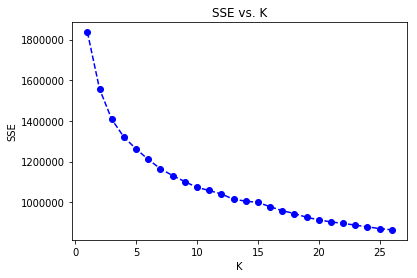

In [142]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

scores = []
centers = list(range(1,27))

for center in centers:
    scores.append(get_kmeans_score(df_sample, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [143]:
def plot_subset(fraction, dataset, n_clusters=27):
    # fraction- the fraction of the dataset to sample
    # dataset- the dataset itself (in this case, X_pca_27)
    # n_clusters- the max number of clusters to plot (X_pca_27 has 27 categories)
    
    # sample the specified fraction of the dataset
    df_subset = pd.DataFrame(dataset).sample(frac = fraction)
    print('Fraction of sample chosen: ', fraction)
    print("Sample number of rows: ", df_subset.shape[0])
    
    # iterate through the desired cluster range and plot
    scores = []
    centers = list(range(1,n_clusters+1))
    
    slope = [-9999999]

    for center in centers:
        scores.append(get_kmeans_score(df_sample, center))
        # calculate the slope of the plot
        # delta N is equal to 1 at each step, so delta score / delta N is equal to delta score
        # arbitrarily set slope to an initial value since it cannot be calculated from the first N
        # calculate a running average of slope
        
        #slope = -9999999
        
        if center > 1:
            #slope = scores[center-1] - scores[center-2]
            slope.append(scores[center-1] - scores[center-2])
        # number of points to average over
        avg_n = 4
        slope_run_avg = -9999999
        if center >= avg_n+1:
            #
            #print(center, center-avg_n, slope[center-avg_n], slope[center-1])
            slope_run_avg = sum(slope[center-avg_n : center]) / avg_n
        elif center != 1:
            slope_run_avg = sum(slope[1:]) / (center-1)
            
        #print('slope running average', slope_run_avg)
        print("SSE Ratio by Clusters: ", center, round(scores[center-1]/scores[0], 3), "slope: ", "{:.2e}".format(slope[center-1]), 
             'slope running average', "{:.2e}".format(slope_run_avg))
    
    plt.plot(centers, scores, linestyle='--', marker='o', color='b');
    plt.xlabel('K');
    plt.ylabel('SSE');
    plt.title('SSE vs. K ');
    

Fraction of sample chosen:  0.001
Sample number of rows:  630
SSE Ratio by Clusters:  1 1.0 slope:  -1.00e+07 slope running average -1.00e+07
SSE Ratio by Clusters:  2 0.848 slope:  -2.80e+05 slope running average -2.80e+05
SSE Ratio by Clusters:  3 0.767 slope:  -1.49e+05 slope running average -2.14e+05
SSE Ratio by Clusters:  4 0.719 slope:  -8.74e+04 slope running average -1.72e+05
SSE Ratio by Clusters:  5 0.687 slope:  -5.84e+04 slope running average -1.44e+05
SSE Ratio by Clusters:  6 0.659 slope:  -5.17e+04 slope running average -8.65e+04
SSE Ratio by Clusters:  7 0.634 slope:  -4.58e+04 slope running average -6.08e+04
SSE Ratio by Clusters:  8 0.616 slope:  -3.32e+04 slope running average -4.73e+04
SSE Ratio by Clusters:  9 0.6 slope:  -2.96e+04 slope running average -4.01e+04
SSE Ratio by Clusters:  10 0.584 slope:  -2.87e+04 slope running average -3.43e+04


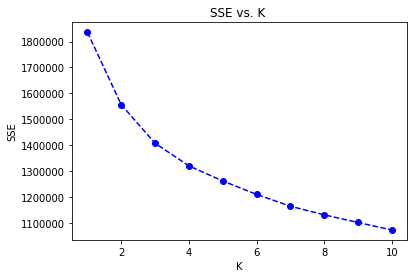

In [144]:
plot_subset(0.001, X_pca_27, 10)

In [145]:
#plot_subset(0.001, X_pca_27, 27)

In [146]:
#plot_subset(0.1, X_pca_27, 27)

Fraction of sample chosen:  1
Sample number of rows:  630050
SSE Ratio by Clusters:  1 1.0 slope:  -1.00e+07 slope running average -1.00e+07
SSE Ratio by Clusters:  2 0.848 slope:  -2.80e+05 slope running average -2.80e+05
SSE Ratio by Clusters:  3 0.767 slope:  -1.49e+05 slope running average -2.14e+05
SSE Ratio by Clusters:  4 0.719 slope:  -8.74e+04 slope running average -1.72e+05
SSE Ratio by Clusters:  5 0.687 slope:  -5.84e+04 slope running average -1.44e+05
SSE Ratio by Clusters:  6 0.659 slope:  -5.17e+04 slope running average -8.65e+04
SSE Ratio by Clusters:  7 0.634 slope:  -4.58e+04 slope running average -6.08e+04
SSE Ratio by Clusters:  8 0.616 slope:  -3.32e+04 slope running average -4.73e+04
SSE Ratio by Clusters:  9 0.6 slope:  -2.96e+04 slope running average -4.01e+04
SSE Ratio by Clusters:  10 0.584 slope:  -2.87e+04 slope running average -3.43e+04
SSE Ratio by Clusters:  11 0.576 slope:  -1.51e+04 slope running average -2.67e+04
SSE Ratio by Clusters:  12 0.567 slope:

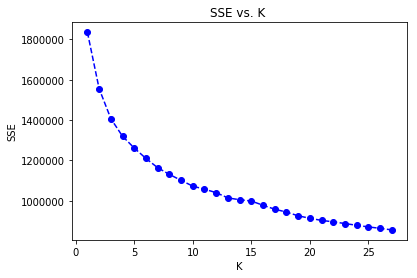

In [147]:
#Run all the data through
plot_subset(1, X_pca_27, 27)

In [148]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [149]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



Fraction of sample chosen:  1
Sample number of rows:  630050
SSE Ratio by Clusters:  1 1.0 slope:  -1.00e+07 slope running average -1.00e+07
SSE Ratio by Clusters:  2 0.848 slope:  -2.80e+05 slope running average -2.80e+05
SSE Ratio by Clusters:  3 0.767 slope:  -1.49e+05 slope running average -2.14e+05
SSE Ratio by Clusters:  4 0.719 slope:  -8.74e+04 slope running average -1.72e+05
SSE Ratio by Clusters:  5 0.687 slope:  -5.84e+04 slope running average -1.44e+05
SSE Ratio by Clusters:  6 0.659 slope:  -5.17e+04 slope running average -8.65e+04
SSE Ratio by Clusters:  7 0.634 slope:  -4.58e+04 slope running average -6.08e+04
SSE Ratio by Clusters:  8 0.616 slope:  -3.32e+04 slope running average -4.73e+04
SSE Ratio by Clusters:  9 0.6 slope:  -2.96e+04 slope running average -4.01e+04
SSE Ratio by Clusters:  10 0.584 slope:  -2.87e+04 slope running average -3.43e+04


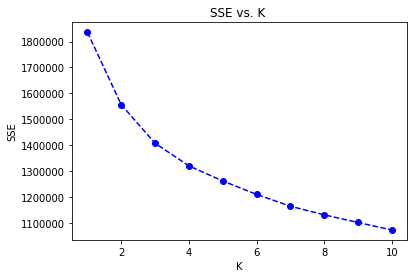

In [150]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

num_clusters = 10

#Re-Run all the data through with the final decided number of clusters
plot_subset(1, X_pca_27, num_clusters)


# Re instantiating the model with the num_clusters no. of centers
kmeans_10 = KMeans(n_clusters = num_clusters, random_state = 42) #instantiate your model ### random_state = 42 for consistency

# Then fit the model to df_sample using the fit method
model_10 = kmeans_10.fit(X_pca_27) #fit the model to your data using kmeans_10

# Finally predict the labels on the same data to show the category that point belongs to
labels_10 = model_10.predict(X_pca_27) #predict labels using model_10 on the dataset

#print(labels_10)

In [151]:
print(labels_10)
X_pca_27_df = pd.DataFrame(X_pca_27)
X_pca_27_df.head()
print(np.unique(labels_10))
(unique, cluster_label_counts) = np.unique(labels_10, return_counts=True)
print(unique, cluster_label_counts)
cluster_proportions = cluster_label_counts / X_pca_27.shape[0]
print(cluster_proportions)

[8 5 4 ..., 8 1 6]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9] [ 50944  55448  51369  89029  80593 104032  68755  65434  61818   2628]
[ 0.08085707  0.08800571  0.08153162  0.14130466  0.12791524  0.16511705
  0.10912626  0.10385525  0.09811602  0.0041711 ]


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

***

<font color=blue>

#### Plotting the Sum of Squared Error vs number of Clusters shows a definite knee
- However, there is not a definitive leveling off such that the number of clusters to retain is obvious. 
- The trend is very similar for random samples of data of different sizes
- Time to calculate the plot is more dependent on calculating the numbers of clusters as opposed to the number of rows that clustering is performed on
- The slope of the Sum of Squared Error (SSE) vs No. of Clusters was tracked to get some kind of insight- the idea being that as slope "tapers off" there is some indication of decreasing value of retaining remaining clusters. The running average of 4 slope values was monitored to alleviate some of the noise in the slope. This approach still requires determining a somewhat arbitrary / subjective cutoff threshold. The desire is to retain an adequate number of clusters without overfitting the data. 
- Ultimately, it was decided to retain 10 clusters. The slope appears to adequately taper off at about this point. This seemed to be a good compromise, while staying to the "higher cluster side" of the knee.


</font>

***

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [152]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')


In [153]:
customers.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,191652.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,188439.000000,188439.000000,188439.000000,188439.000000,188439.000000,188439.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,145056.000000,145056.000000,191652.000000,191652.000000,145056.000000,145056.000000,145056.000000,188684.000000,79715.000000,137910.000000,145056.000000,141725.000000,139542.000000,141725.000000,145001.000000,141725.000000,141725.000000,135672.000000,135672.000000,135672.000000,135672.000000,135672.000000,135672.000000,141693.000000,141693.000000,141693.000000,141725.000000,137392.000000,135672.000000,188439.000000,137392.000000,140371.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,141176.000000,141176.000000,141176.000000
mean,0.344359,3.060907,1.376432,3.677928,3.963773,2.057051,4.183317,2.439808,2.646176,2.781176,4.137958,1003.392733,6.302268,0.367171,1.198396,18.181571,5.422694,4.254448,2.355043,6.687910,3.209251,0.773433,4.248273,3.716311,3.742137,4.414026,4.112788,3.883163,4.185279,5.366477,4.408021,3.682497,3.165879,4.674535,4.483835,4.187246,3.528254,2.919161,0.987754,0.009865,0.021681,0.849008,2.576806,11.352009,2.267828,0.020392,2.942481,3.421803,4.152716,8.646371,4.965863,0.067413,2.369942,3.129978,1993.056659,3.723133,2.207058,1.209004,0.309968,0.153385,1.043826,3.630403,4.301758,3.881702,4.784577,3.852524,2.321569,3.627425,2.764327,3.814341,667.231216,2.537404,2.731510,1.388817,0.539939,1.556607,3.634893,3.622192,2.824850,5.119517,2.898510
std,1.391672,1.086254,0.484492,1.813975,1.036230,1.319422,0.995365,1.697932,1.586506,1.147353,1.503946,974.531081,2.877181,0.482035,1.450937,15.009985,4.717907,4.492807,2.052142,3.090573,1.436958,0.495983,3.807671,1.113933,1.718039,1.733128,2.070958,1.840131,2.367407,1.443103,1.720909,1.573090,1.316221,2.041059,1.631941,1.872047,1.493916,1.219224,1.538679,0.098833,0.210424,1.166162,1.168486,6.275026,1.390620,0.152234,1.533347,1.623890,1.974375,1.154001,14.309694,0.545576,2.434227,1.439740,3.080241,2.095540,1.383509,1.086202,0.765292,0.476992,1.384973,1.168496,2.114614,1.607621,1.961473,0.830285,1.100512,1.282444,1.266050,2.075155,340.481722,0.904927,0.840922,0.885038,0.637048,1.185736,0.933660,1.008472,1.012415,2.159184,1.422683
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00

In [154]:
# Apply the cleaning function on the Customer Data

customers_clean_df = clean_data(customers, new_mi_list)

initial shape:  (191652, 85)
shape after dropping 5 columns:  (191652, 80)
Row numbers searched:  0
Row numbers searched:  50000
Row numbers searched:  100000
Row numbers searched:  150000
shape before removing rows:  (191652, 80)
shape after removing rows:  (116246, 81)
shape after dropping missing points criterion:  (116246, 80)
shape after replacing PJ with 2 new columns:  (116246, 81)
0 13 ones:  3 tens:  10
2 34 ones:  4 tens:  30
4 41 ones:  1 tens:  40
5 34 ones:  4 tens:  30
6 23 ones:  3 tens:  20
7 15 ones:  5 tens:  10
9 15 ones:  5 tens:  10
final shape:  (116246, 68)


In [155]:
#Check how many NaN exist in cleaned Customer dataset

#df_lte_1.isnull().sum().sum()
count_nan_in_cc_df = customers_clean_df.isnull().sum()

pd.set_option('display.max_columns', 85)
pd.set_option('display.max_rows', 70)
print (count_nan_in_cc_df)

ALTERSKATEGORIE_GROB         0
ANREDE_KZ                    0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
GREEN_AVANTGARDE             0
HEALTH_TYP                   0
LP_LEBENSPHASE_FEIN          0
PJ_movement                 97
PJ_decade                   97
RETOURTYP_BK_S               0
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
SEMIO_KRIT                   0
SEMIO_DOM                    0
SEMIO_KAEM                   0
SEMIO_PFLICHT                0
SEMIO_TRADV                  0
SOHO_KZ                      0
VERS_TYP                     0
ALTER_HH                 16807
ANZ_PERSONEN                 0
ANZ_TITE

In [156]:
# create a dictionary that uses the values from ALTERSKATEGORIE_GROB as keys 
# and uses the values from ALTER_HH that we want to replace for the NaNs
# create 'copy_col_cust' that starts with a copy of the ALTERSKATEGORIE_GROB column 
# and replaces values 1-4 with the dictionary values
# This dictionary was created earlier and can be used on customer data
#replace_dict = {1.0:18.0, 2.0:17.0, 3.0:15.0, 4.0:10.0}


###PUT THIS BACK IN########
copy_col_cust = customers_clean_df['ALTERSKATEGORIE_GROB'].replace(to_replace = replace_dict)
#print(copy_col_cust)

customers_clean_df.insert(customers_clean_df.columns.get_loc('ALTERSKATEGORIE_GROB'), 'copy_col_cust',copy_col_cust)


# Use .fillna() to replace the NaNs in 'ALTER_HH' with the values from 'copy_col'

customers_clean_df.ALTER_HH.fillna(customers_clean_df.copy_col_cust, inplace=True)
#print(customers_clean_df.loc[customers_clean_df['ALTERSKATEGORIE_GROB'] == 1]['ALTER_HH'])

#Check that NaNs are eliminated from 'ALTER_HH'
print("NaN remaining in ALTER_HH (should be 0): ", customers_clean_df['ALTER_HH'].isnull().sum())



NaN remaining in ALTER_HH (should be 0):  0


In [157]:
# remove 'copy_col_cust' from the dataframe

#df_lte_1.drop(columns = ['copy_col'], inplace = True)
customers_clean_df.drop(columns = ['copy_col_cust'], inplace = True)

#Check again how many NaN exist in Customer dataset

#customers_clean_df.isnull().sum().sum()
count_nan_in_df=customers_clean_df.isnull().sum()

pd.set_option('display.max_columns', 85)
pd.set_option('display.max_rows', 70)
#print (count_nan_in_df)

#impute missing data

filling_missing_cust = Imputer(strategy='most_frequent') 

customers_clean_df_impute = pd.DataFrame(filling_missing_cust.fit_transform(customers_clean_df))

customers_clean_df_impute.columns = customers_clean_df.columns

customers_clean_df_impute.index = customers_clean_df.index

# Check that no NaN remain after imputing above
count_nan_in_df = customers_clean_df_impute.isnull().sum()

pd.set_option('display.max_columns', 85)
pd.set_option('display.max_rows', 70)
print ("NaN in Customer data now: \n", count_nan_in_df)

NaN in Customer data now: 
 ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
LP_LEBENSPHASE_FEIN      0
PJ_movement              0
PJ_decade                0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
SOHO_KZ                  0
VERS_TYP                 0
ALTER_HH                 0
ANZ_PERSONEN             0
ANZ_TITEL                0
HH_EINKOMMEN_SCORE       0
W_KEIT_KIND_HH           0
WOHNDAUER_2008           0


In [158]:
#verify same number of columns in same order between customer set and full demographics data

'''for col in customers_clean_df_impute.columns:
    print(col)'''
customers_clean_df_impute.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,PJ_movement,PJ_decade,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CI_Wealth,CI_LIFE_STAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,20.0,2.0,2.0,5.0,6.0,5.0,2.0,6.0,6.0,7.0,3.0,4.0,1.0,3.0,1.0,1.0,2.0,1.0,0.0,1.0,10.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,2.0,7.0,10.0,3.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,13.0,2.0,2.0,5.0,2.0,2.0,1.0,3.0,3.0,7.0,7.0,1.0,2.0,7.0,5.0,6.0,4.0,1.0,0.0,2.0,6.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,2.0,2.0,30.0,4.0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,31.0,1.0,4.0,5.0,4.0,5.0,4.0,6.0,5.0,6.0,4.0,5.0,5.0,3.0,5.0,2.0,5.0,4.0,0.0,2.0,20.0,4.0,0.0,6.0,2.0,9.0,7.0,0.0,1.0,1992.0,2.0,3.0,40.0,1.0,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,17.0,2.0,2.0,3.0,6.0,4.0,4.0,1.0,7.0,6.0,4.0,6.0,2.0,5.0,5.0,3.0,3.0,4.0,0.0,2.0,11.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,2.0,1992.0,2.0,1.0,30.0,4.0,2.0,2.0,1.0,0.0,3.0,7.0,5.0,8.0,4.0,2.0,3.0,3.0,3.0,1167.0,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
6,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,20.0,2.0,2.0,5.0,4.0,2.0,5.0,1.0,6.0,5.0,3.0,4.0,3.0,3.0,1.0,2.0,2.0,4.0,0.0,1.0,10.0,2.0,0.0,2.0,6.0,9.0,1.0,0.0,4.0,1992.0,2.0,7.0,20.0,3.0,4.0,1.0,0.0,0.0,4.0,6.0,2.0,5.0,4.0,2.0,4.0,4.0,3.0,1300.0,3.0,2.0,1.0,0.0,1.0,5.0,5.0,2.0,3.0,2.0


In [159]:
df_lte_1_impute.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,PJ_movement,PJ_decade,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CI_Wealth,CI_LIFE_STAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,21.0,1.0,6.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,18.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,2.0,4.0,50.0,1.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,3.0,2.0,6.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,17.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,2.0,2.0,20.0,4.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,32.0,1.0,4.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,2.0,20.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,2.0,3.0,40.0,3.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,8.0,1.0,2.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,2.0,10.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,2.0,7.0,50.0,4.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,2.0,1.0,5.0,4.0,2.0,5.0,5.0,7.0,2.0,6.0,5.0,5.0,7.0,7.0,4.0,7.0,7.0,7.0,0.0,1.0,17.0,1.0,0.0,6.0,3.0,9.0,4.0,0.0,5.0,1992.0,2.0,5.0,20.0,2.0,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0


In [160]:
'''
Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. 
That is, you should not be using a .fit() or .fit_transform() method to re-fit the old objects, 
nor should you be creating new sklearn objects! 
Carry the data through the feature scaling, PCA, and clustering steps, 
obtaining cluster assignments for all of the data in the customer demographics data.
'''

'''- You should use the same object for the 2 datasets

ss = StandardScaler()

scaled_df = pd.DataFrame(ss.fit_transform(df_lte_1_impute))

scaled_customer_df = ss.transform(customers_clean_df_impute)

we here should use ss object for the 2 datasets but you used the general dataset after being scaled
and you want to apply it to the customers dataset and it is wrong !

- Follow up with me in comments to this answer if anything isn't clear !

- Good Luck !'''


# Apply feature scaling to the Customer demographics data.

scaled_customer_df = ss.transform(customers_clean_df_impute)




In [161]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Dimensionality Reduction: Principal Component Analysis
# perform PCA using the same number of components as done on the Azdias data:

##### DO NOT REDO PCA#########

'''customer_pca_27, customer_X_pca_27 = do_pca(27, scaled_customer_df)

#Scree plot with 27 principal components for Customer Data
scree_plot(customer_pca_27)

#Print out principal component explained variance
print(customer_pca_27.explained_variance_ratio_)
customer_pca_27.explained_variance_ratio_.sum()
'''

'customer_pca_27, customer_X_pca_27 = do_pca(27, scaled_customer_df)\n\n#Scree plot with 27 principal components for Customer Data\nscree_plot(customer_pca_27)\n\n#Print out principal component explained variance\nprint(customer_pca_27.explained_variance_ratio_)\ncustomer_pca_27.explained_variance_ratio_.sum()\n'

In [162]:
#pca_27 is the object that was created when the demographics PCA was performed
# The following will store the reduced data that was created from the PCA on the demographics data
#pca_27, X_pca_27 = do_pca(27, scaled_df)

#SO- reuse the pca_27 to use the same principal components as the demographics data
#print(pca_27)
customer_X_pca_27 = pca_27.transform(scaled_customer_df)



In [163]:
print(customer_X_pca_27)
print(X_pca_27)
print(customer_X_pca_27.shape)
print(X_pca_27.shape)


[[-6.15463836  0.79893422  4.23054835 ...,  0.57837878 -1.38282854
  -0.05105867]
 [-1.80160422  5.25528289 -0.69071851 ...,  0.88316512  0.49998075
   0.43576513]
 [ 1.33327763 -1.17441216  1.05602089 ...,  0.83870481  0.84067105
   0.64605316]
 ..., 
 [-4.8639565   2.21099622  2.21366845 ..., -1.40691152  0.66293882
  -0.24200599]
 [-1.51398126  2.47070059 -2.14382424 ..., -0.42196194  0.83860588
   1.93243938]
 [-3.89276342 -3.11853743  2.34180112 ..., -0.59161452 -0.84142092
  -0.47623192]]
[[ 3.65069687 -2.85659837 -2.88638741 ..., -0.93197232  0.0228805
   0.44005043]
 [-0.89718562 -0.10818319 -3.11317506 ..., -0.91296237 -0.20152546
   0.36286322]
 [ 0.38996384 -0.07086525  3.05525261 ..., -0.06315639 -0.78270598
   0.14109709]
 ..., 
 [ 3.59563098 -2.0179036  -3.53760354 ..., -0.06823838 -0.14246214
  -0.57448381]
 [ 6.05356146 -2.99269215  2.3424596  ...,  1.14371859  0.27281341
  -0.39161005]
 [-0.91896542  1.36050699  2.92198907 ..., -1.4914177  -0.50551989
  -0.235645  ]]
(

In [164]:
#Run all the Customer data through the K means clustering and plotting function
# Recall- It was decided to retain 10 clusters
'''plot_subset(1, customer_X_pca_27, 10)'''

'plot_subset(1, customer_X_pca_27, 10)'

In [165]:
####### DO NOT CALCULATE CLUSTERS ON CUSTOMER DATA#########
# Re instantiating the Customer model with the num_clusters no. of centers
'''num_clusters = 10 # as with the full demographics data
customer_kmeans_10 = KMeans(n_clusters = num_clusters, random_state = 42) #instantiate your model 
## random_state to be consistent

# Then fit the model to df_sample using the fit method
customer_model_10 = customer_kmeans_10.fit(customer_X_pca_27) #fit the model to your data using customer_kmeans_10


# Finally predict the labels on the same data to show the category that point belongs to
customer_labels_10 = customer_model_10.predict(customer_X_pca_27) #predict labels using model_10 on the dataset


(customer_unique, customer_cluster_label_counts) = np.unique(customer_labels_10, return_counts=True)
print(customer_unique, customer_cluster_label_counts)'''

# Finally predict the labels on the same data to show the category that point belongs to
# model_10 was used for the full demographics data

customer_labels_10 = model_10.predict(customer_X_pca_27) #predict labels using model_10 on the dataset

(customer_unique, customer_cluster_label_counts) = np.unique(customer_labels_10, return_counts=True)
print(customer_unique, customer_cluster_label_counts)

[0 1 2 3 4 5 6 7 8 9] [ 1835  1074 40968 11825 12427 22149 20732  1739  1023  2474]


In [166]:
customer_cluster_proportions = customer_cluster_label_counts / customer_X_pca_27.shape[0]
print(customer_cluster_proportions)

[ 0.01578549  0.00923903  0.35242503  0.10172393  0.1069026   0.19053559
  0.17834592  0.01495965  0.0088003   0.02128245]


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

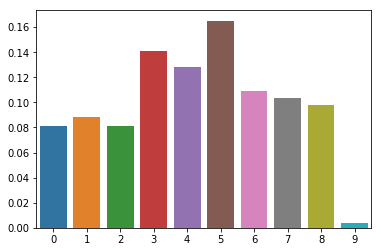

In [167]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

#cluster_ratios = np.divide(, )
sns.barplot(unique, cluster_proportions)


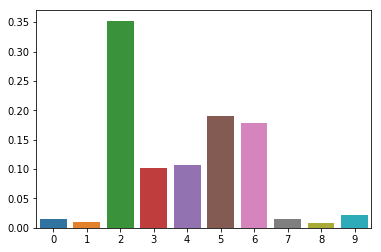

In [168]:
sns.barplot(unique, customer_cluster_proportions)

percent change per label:  [ -80.47729351  -89.50178667  332.25562099  -28.01091523  -16.42700348
   15.39425121   63.43080197  -85.59566841  -91.03071794  410.23627634]
customer cluster proportions:  [ 0.01578549  0.00923903  0.35242503  0.10172393  0.1069026   0.19053559
  0.17834592  0.01495965  0.0088003   0.02128245]
general demographics cluster proportions:  [ 0.08085707  0.08800571  0.08153162  0.14130466  0.12791524  0.16511705
  0.10912626  0.10385525  0.09811602  0.0041711 ]


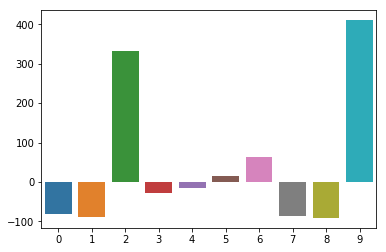

In [169]:
# Plot the percent change between the two different cluster proportions:
pct_change = (customer_cluster_proportions - cluster_proportions)/cluster_proportions *100
print('percent change per label: ', pct_change)
print('customer cluster proportions: ', customer_cluster_proportions)
print('general demographics cluster proportions: ', cluster_proportions)
#print(type(pct_change))
sns.barplot(unique, pct_change)

***

<font color=blue>

#### There are some large differences between the data sets
- Cluster 0 is over represented in the customer data relative to the general demographics
- Cluster 8 is under represented in the customer data relative to the general population

</font>

***

In [170]:
#print(customers_clean_df[customer_labels_10 == 0].shape)
print(customer_X_pca_27[customer_labels_10 == 9].shape)
print(pd.DataFrame(customer_X_pca_27[customer_labels_10 == 9]).columns.values)
print(len(pd.DataFrame(customer_X_pca_27[customer_labels_10 == 9]).columns.values))


(2474, 27)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
27


In [171]:
# Look at the first 3 Principal Components for the General Demographics Data for Cluster 0
(pd.DataFrame(X_pca_27[labels_10 == 0]).iloc[:,:3]).describe()

,0,1,2
count,50944.000000,50944.000000,50944.000000
mean,-0.507837,-4.816928,2.073691
std,1.638576,1.289367,0.900871
min,-5.913287,-8.332017,-1.148595
25%,-1.738805,-5.762349,1.586923
50%,-0.512698,-4.924065,2.168233
75%,0.776163,-3.994154,2.672014
max,3.190632,-0.587342,5.080714


In [172]:
# Look at the first 3 Principal Components for the Customer Data for Cluster 0
(pd.DataFrame(customer_X_pca_27[customer_labels_10 == 0]).iloc[:,:3]).describe()

,0,1,2
count,1835.000000,1835.000000,1835.000000
mean,-1.500141,-4.411164,2.298966
std,1.615417,1.289024,1.057571
min,-5.334962,-7.758592,-0.671391
25%,-2.749400,-5.300281,1.617694
50%,-1.623178,-4.409394,2.416327
75%,-0.327118,-3.546274,3.083793
max,2.686367,-0.805526,4.892902


In [173]:
# Look at the first 3 Principal Components for the General Demographics Data for Cluster 4
(pd.DataFrame(X_pca_27[labels_10 == 4]).iloc[:,:3]).describe()

,0,1,2
count,80593.000000,80593.000000,80593.000000
mean,2.042769,2.308943,2.684571
std,1.619752,1.463657,0.835506
min,-2.267644,-1.959470,-0.727537
25%,0.788367,1.223220,2.079052
50%,1.998747,2.249688,2.653561
75%,3.302098,3.368410,3.268933
max,8.460295,7.419178,5.731845


In [174]:
# Look at the first 3 Principal Components for the Customer Data for Cluster 4
(pd.DataFrame(customer_X_pca_27[customer_labels_10 == 4]).iloc[:,:3]).describe()

,0,1,2
count,12427.000000,12427.000000,12427.000000
mean,1.303668,2.876733,3.169159
std,1.530058,1.364653,0.806988
min,-2.251211,-1.832132,-0.788925
25%,0.099425,1.986307,2.626595
50%,1.191224,2.955906,3.196780
75%,2.438210,3.851037,3.722926
max,8.097649,7.024322,6.221002


In [175]:
'''for i in range(0, 10):
    print((pd.DataFrame(customer_X_pca_27[customer_labels_10 == i]).iloc[:,:3]).median())
    print((pd.DataFrame(X_pca_27[labels_10 == i]).iloc[:,:3]).median())
'''

'for i in range(0, 10):\n    print((pd.DataFrame(customer_X_pca_27[customer_labels_10 == i]).iloc[:,:3]).median())\n    print((pd.DataFrame(X_pca_27[labels_10 == i]).iloc[:,:3]).median())\n'

In [176]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

'''from sklearn import decomposition
from sklearn import datasets'''

# Cluster 0 was overrepresented in the customer data

#print(ss.inverse_transform(customer_pca_27.inverse_transform(customer_kmeans_10.cluster_centers_)).shape)
print(ss.inverse_transform(pca_27.inverse_transform(kmeans_10.cluster_centers_)).shape)
#customer_pca_27.inverse_transform(customer_kmeans_10.cluster_centers_)
#customer_kmeans_10.cluster_centers_

# Each row is a cluster (all 10 clusters), and the columns for Customer Data?
#ss.inverse_transform(customer_pca_27.inverse_transform(customer_kmeans_10.cluster_centers_))[:, 0:3]
#ss.inverse_transform(customer_pca_27.inverse_transform(customer_kmeans_10.cluster_centers_))
ss.inverse_transform(pca_27.inverse_transform(kmeans_10.cluster_centers_))[:, 0:3]

(10, 68)


array([[ 1.79268881,  0.95867127,  2.91332516],
       [ 1.86439955,  0.95334705,  1.91937088],
       [ 3.29715206,  1.07368592,  4.82147326],
       [ 3.55009755,  1.96516386,  2.44245523],
       [ 3.33896293,  1.04937885,  3.33803591],
       [ 3.51846174,  1.92763954,  3.85467986],
       [ 3.32695845,  1.09368779,  4.38310912],
       [ 1.695788  ,  2.00480771,  2.30185032],
       [ 1.54760558,  2.02560061,  1.16959022],
       [ 3.12204112,  1.45777287,  3.55111771]])

In [177]:
# Below is 10 clusters with the 68 columns after transformation, before PCA 
print(pca_27.inverse_transform(kmeans_10.cluster_centers_).shape)
pca_27.inverse_transform(kmeans_10.cluster_centers_)

(10, 68)


array([[ -9.71106045e-01,  -1.10603282e+00,  -1.02601073e-01,
          9.68155082e-01,  -9.02137027e-01,   7.26586210e-01,
          1.02180430e+00,  -4.97516528e-01,   1.67436706e-01,
          2.68456436e-02,   1.71637750e-01,   1.67436706e-01,
          9.79407701e-01,  -6.08194314e-01,   1.00559947e+00,
          1.25050506e+00,   1.27706949e+00,   6.24377651e-01,
          1.01348717e+00,  -5.52909765e-01,  -1.36176477e+00,
          1.36313210e+00,   2.23465568e-01,  -1.18114953e+00,
         -1.05625657e+00,  -1.23687033e+00,   8.32649040e-01,
          7.53140451e-01,   2.04114713e-02,  -9.14127685e-02,
          8.86385290e-01,   3.14900099e-01,  -6.25659687e-02,
         -3.01200024e-01,  -2.66179597e-01,  -1.87632908e-01,
         -3.03305251e-01,  -1.02314364e-01,   3.59703909e-01,
          1.05277261e-01,   1.51035331e-01,   2.39757794e-01,
         -4.70224818e-01,   2.24743482e-01,   4.95000018e-01,
          8.50244829e-02,  -3.06256791e-01,  -3.87924090e-01,
        

In [178]:
# customer_kmeans_10.cluster centers consists of 10 clusters with 27 principal components per cluster
print(kmeans_10.cluster_centers_.shape)
# the following prints the first 3 Principal components for each cluster row
kmeans_10.cluster_centers_[:, 0:3]

(10, 27)


array([[-0.51000267, -4.81742946,  2.07335355],
       [ 4.66810387, -2.19338935,  2.5140819 ],
       [-3.4141153 , -0.1315678 ,  2.66861442],
       [ 1.49213903,  4.09514439, -1.6947374 ],
       [ 2.04349535,  2.30922727,  2.68460367],
       [-3.70754613,  1.33708879, -1.94107596],
       [-3.18854393, -0.27148757,  1.80268154],
       [-0.63124436, -3.42587413, -3.11428971],
       [ 4.73458927, -1.24886829, -2.72683715],
       [-0.57802747,  1.54717822,  1.04563957]])

In [179]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Cluster 6 was very underrepresented in the customer data relative to the genereal population


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.